In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec
from matplotlib import patches
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

import os
import math
import random

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.metrics import roc_curve, roc_auc_score, auc

import scipy.stats as st
from scipy.stats import poisson
from scipy.interpolate import interp1d
from scipy.stats import norm
from scipy.stats import multivariate_normal

In [2]:
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

import scipy.integrate as integrate

In [3]:
!pip install xgboost

import xgboost
from xgboost import XGBRegressor, XGBClassifier

You should consider upgrading via the '/home/andres/anaconda3/bin/python -m pip install --upgrade pip' command.


### MULTIVARIATE GAUSSIAN DISTRIBUTION dim=2

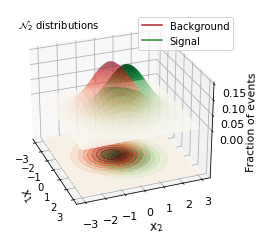

In [4]:
# PLOT 2 MULTIVARIATE GAUSSIAN DISTRIBUTIONS

# Our 2-dimensional distribution will be over variables X and Y
N = 80
X = np.linspace(-3, 3, N)
Y = np.linspace(-3, 3, N)
X, Y = np.meshgrid(X, Y)

# Mean vector and covariance matrix
mu = np.array([0.3, 0.3])
mu2 = np.array([-0.3, -0.3])
Sigma = np.array([[ 1. , 0], [0,  1]])

# Pack X and Y into a single 3-dimensional array
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

def multivariate_gaussian(pos, mu, Sigma):
    """Return the multivariate Gaussian distribution on array pos.

    pos is an array constructed by packing the meshed arrays of variables
    x_1, x_2, x_3, ..., x_k into its _last_ dimension.

    """

    n = mu.shape[0]
    Sigma_det = np.linalg.det(Sigma)
    Sigma_inv = np.linalg.inv(Sigma)
    N = np.sqrt((2*np.pi)**n * Sigma_det)
    # This einsum call calculates (x-mu)T.Sigma-1.(x-mu) in a vectorized
    # way across all the input variables.
    fac = np.einsum('...k,kl,...l->...', pos-mu, Sigma_inv, pos-mu)

    return np.exp(-fac / 2) / N

# The distribution on the variables X, Y packed into pos.
Z = multivariate_gaussian(pos, mu, Sigma)
Z2 = multivariate_gaussian(pos, mu2, Sigma)

# Create a surface plot and projected filled contour plot under it.
fig = plt.figure()
#ax = fig.gca(projection='3d')
ax = plt.subplot(projection='3d')

z_aux = np.linspace(2, 2, 2)
x_aux = z_aux
y_aux = z_aux

ax.plot(x_aux, y_aux, z_aux, color='firebrick', label='Background')
ax.plot(x_aux, y_aux, z_aux, color='forestgreen', label='Signal')
ax.legend(loc={0.6,0.8})

ax.plot_surface(X, Y, Z, rstride=1, cstride=1, linewidth=1, antialiased=True,
                cmap=cm.Greens)
ax.plot_surface(X, Y, Z2, rstride=3, cstride=3, linewidth=1, antialiased=True,alpha=0.4,
                cmap=cm.Reds)

cset = ax.contourf(X, Y, Z, zdir='z', offset=-0.15, cmap=cm.Greens)
cset2 = ax.contourf(X, Y, Z2, zdir='z', offset=-0.15, cmap=cm.Reds,alpha=0.5)

# Adjust the limits, ticks and view angle
ax.set_facecolor("white")
ax.set_zlim(-0.15,0.15)
ax.set_zticks(np.linspace(0,0.15,4))
ax.view_init(27, -21)
plt.xlabel("$x_1$",fontsize=12)
plt.ylabel("$x_2$",fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=11)
ax.zaxis.set_tick_params(labelsize=11)

ax.text2D(0.05, 0.9, "$\mathcal{N}_{2}$ distributions", transform=ax.transAxes)
ax.text2D(1.1, 0.25, "Fraction of events", transform=ax.transAxes, rotation=89, fontsize=11)
#plt.savefig('images/' + '2gaussian-distributions.pdf', format="pdf", bbox_inches="tight")
plt.show()

### Gaussians

In [5]:
##############
# PARAMETERS #
##############

# gaussian, mean
epsilon = 0.3

# number of events
N = 1000000

# requested number of ensembles
n_ensembles = 5000

# number of expected background events per ensemble
B_expected = 50000

# ratio S_expected/B_expected (signal ratio)
SB_ratio = [0.001, 0.0025, 0.005, 0.0075, 0.01, 0.025, 0.05, 0.075]





# SOME USEFUL DERIVATED PARAMETERS:

# S_expected:
S_expected = [ int(SB_ratio[iii]*B_expected) for iii in range(len(SB_ratio)) ]

# S/\sqrt{B}
SsqrtB = [ S_expected[iii]/(B_expected)**0.5 for iii in range(len(SB_ratio)) ]

(1000000, 2)
(1000000, 1)
(1000000, 2)
(1000000, 1)


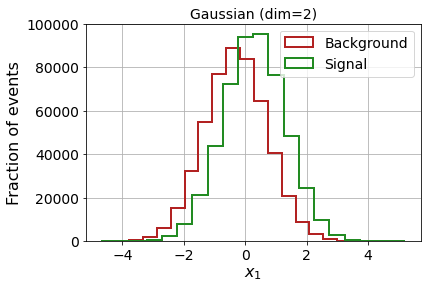

In [64]:
#######################
# generate the events #
#######################
    
background_X_1 = np.random.normal(-epsilon,1,N)
background_X_2 = np.random.normal(-epsilon,1,N)
    
signal_X_1 = np.random.normal(epsilon,1,N)
signal_X_2 = np.random.normal(epsilon,1,N)

dim1 = np.concatenate((background_X_1,signal_X_1))
dim2 = np.concatenate((background_X_2,signal_X_2))

# labels
background_Y = np.zeros(N)
signal_Y = np.ones(N)

# DATA in a single matrix (features + labels)
df = pd.DataFrame()
df['dim1'] = dim1.reshape(-1)
df['dim2'] = dim2.reshape(-1)
df['Y'] = np.concatenate((background_Y.astype('int'),signal_Y.astype('int')))

X_gauss = df[['dim1','dim2']].values 
Y_gauss = df[['Y']].values

X_gauss_train, X_gauss_val, Y_gauss_train, Y_gauss_val = train_test_split(X_gauss, Y_gauss, test_size=0.5)


print(X_gauss_train.shape)
print(Y_gauss_train.shape)
print(X_gauss_val.shape)
print(Y_gauss_val.shape)


# PLOT (only 1st feature) to visualize the data
X_gauss_val_SM = []
X_gauss_val_NP = []

for i in range(len(Y_gauss_val)):
    if Y_gauss_val[i] ==0:
        X_gauss_val_SM.append(X_gauss_val[i].tolist())
    else:
        X_gauss_val_NP.append(X_gauss_val[i].tolist())    


X_gauss_val_SM = np.array(X_gauss_val_SM)
X_gauss_val_NP = np.array(X_gauss_val_NP)


weights = np.ones_like(X_gauss_val_SM[:,0])/float(len(X_gauss_val_SM[:,0]))
plt.hist(X_gauss_val_SM[:,0], 20, histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(X_gauss_val_NP[:,0])/float(len(X_gauss_val_NP[:,0]))
plt.hist(X_gauss_val_NP[:,0], 20, histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$x_1$",fontsize=16)
plt.ylabel("Fraction of events",fontsize=16)
plt.grid()
plt.legend(fontsize=14)
plt.title(r"Gaussian (dim=2)",fontsize=14)
plt.show()  

(1000000, 2)
(1000000, 1)


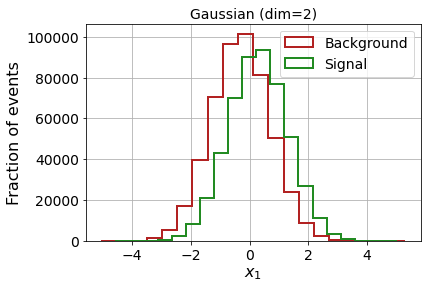

In [65]:
N_test = int(N/2)

background_X_1_test = np.random.normal(-epsilon,1,N_test)
background_X_2_test = np.random.normal(-epsilon,1,N_test)
    
signal_X_1_test = np.random.normal(epsilon,1,N_test)
signal_X_2_test = np.random.normal(epsilon,1,N_test)

dim1 = np.concatenate((background_X_1_test,signal_X_1_test))
dim2 = np.concatenate((background_X_2_test,signal_X_2_test))

# labels
background_Y_test = np.zeros(N_test)
signal_Y_test = np.ones(N_test)

# DATA in a single matrix (features + labels)
df = pd.DataFrame()
df['dim1'] = dim1.reshape(-1)
df['dim2'] = dim2.reshape(-1)
df['Y'] = np.concatenate((background_Y_test.astype('int'),signal_Y_test.astype('int')))

X_gauss_test = df[['dim1','dim2']].values 
Y_gauss_test = df[['Y']].values


print(X_gauss_test.shape)
print(Y_gauss_test.shape)



# PLOT (only 1st feature) to visualize the data
X_gauss_test_SM = []
X_gauss_test_NP = []

for i in range(len(Y_gauss_test)):
    if Y_gauss_test[i] ==0:
        X_gauss_test_SM.append(X_gauss_test[i].tolist())
    else:
        X_gauss_test_NP.append(X_gauss_test[i].tolist())    


X_gauss_test_SM = np.array(X_gauss_test_SM)
X_gauss_test_NP = np.array(X_gauss_test_NP)


weights = np.ones_like(X_gauss_test_SM[:,0])/float(len(X_gauss_test_SM[:,0]))
plt.hist(X_gauss_test_SM[:,0], 20, histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(X_gauss_test_NP[:,0])/float(len(X_gauss_test_NP[:,0]))
plt.hist(X_gauss_test_NP[:,0], 20, histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$x_1$",fontsize=16)
plt.ylabel("Fraction of events",fontsize=16)
plt.grid()
plt.legend(fontsize=14)
plt.title(r"Gaussian (dim=2)",fontsize=14)
plt.show()  

In [66]:
# the true pdfs (useful later)

mean_sig = [epsilon, epsilon]
mean_bkg = [-1*x for x in mean_sig]

cov_sig = [[1,0.],[0.,1]]
cov_bkg = cov_sig

sig_multi = multivariate_normal(mean_sig, cov_sig)
bkg_multi = multivariate_normal(mean_bkg, cov_bkg)

### XGBoost (per-event)

##### For 1 ML

[0]	validation_0-logloss:0.67906	validation_1-logloss:0.67913
[1]	validation_0-logloss:0.66754	validation_1-logloss:0.66773
[2]	validation_0-logloss:0.65798	validation_1-logloss:0.65822


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[3]	validation_0-logloss:0.65009	validation_1-logloss:0.65039
[4]	validation_0-logloss:0.64354	validation_1-logloss:0.64396
[5]	validation_0-logloss:0.63806	validation_1-logloss:0.63853
[6]	validation_0-logloss:0.63350	validation_1-logloss:0.63404
[7]	validation_0-logloss:0.62964	validation_1-logloss:0.63026
[8]	validation_0-logloss:0.62642	validation_1-logloss:0.62708
[9]	validation_0-logloss:0.62372	validation_1-logloss:0.62443
[10]	validation_0-logloss:0.62142	validation_1-logloss:0.62220
[11]	validation_0-logloss:0.61949	validation_1-logloss:0.62035
[12]	validation_0-logloss:0.61787	validation_1-logloss:0.61882
[13]	validation_0-logloss:0.61650	validation_1-logloss:0.61752
[14]	validation_0-logloss:0.61532	validation_1-logloss:0.61646
[15]	validation_0-logloss:0.61433	validation_1-logloss:0.61555
[16]	validation_0-logloss:0.61348	validation_1-logloss:0.61479
[17]	validation_0-logloss:0.61274	validation_1-logloss:0.61414
[18]	validation_0-logloss:0.61212	validation_1-logloss:0.61362

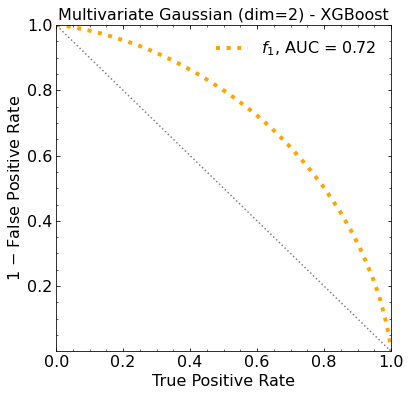

In [67]:
# CLASSIFIER
classifier = XGBClassifier(
    n_estimators=500,
    learning_rate=0.1,
    reg_lambda=0.0,reg_alpha=0.0,
    gamma=0.0,objective='binary:logistic',
    max_depth=5)

# FIT
classifier.fit(X_gauss_train[:100000],Y_gauss_train[:100000],eval_set=[(X_gauss_train[:100000], Y_gauss_train[:100000]), (X_gauss_val, Y_gauss_val)],
        eval_metric='logloss',early_stopping_rounds=50,#early stopping
        verbose=True)

# PREDICTIONS
y_pred_xg_1ML = classifier.predict_proba(X_gauss_test).T[1]


# ROC
fpr_gauss_xg, tpr_gauss_xg, _ = roc_curve(Y_gauss_test, y_pred_xg_aux_1ML)
roc_auc_xg = auc(fpr_gauss_xg, tpr_gauss_xg)


# PLOT THE ROC WITH AUC
fig = plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax0.minorticks_on()


plt.plot(tpr_gauss_xg,1-fpr_gauss_xg,label="$f_{1}$, AUC = %0.2f" % roc_auc_xg,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.title(r"Multivariate Gaussian (dim=2) - XGBoost",fontsize=16)
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()

##### For 10 ML

ML iteration 1
[0]	validation_0-logloss:0.67906	validation_1-logloss:0.67913
[1]	validation_0-logloss:0.66754	validation_1-logloss:0.66773


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[2]	validation_0-logloss:0.65798	validation_1-logloss:0.65822
[3]	validation_0-logloss:0.65009	validation_1-logloss:0.65039
[4]	validation_0-logloss:0.64354	validation_1-logloss:0.64396
[5]	validation_0-logloss:0.63806	validation_1-logloss:0.63853
[6]	validation_0-logloss:0.63350	validation_1-logloss:0.63404
[7]	validation_0-logloss:0.62964	validation_1-logloss:0.63026
[8]	validation_0-logloss:0.62642	validation_1-logloss:0.62708
[9]	validation_0-logloss:0.62372	validation_1-logloss:0.62443
[10]	validation_0-logloss:0.62142	validation_1-logloss:0.62220
[11]	validation_0-logloss:0.61949	validation_1-logloss:0.62035
[12]	validation_0-logloss:0.61787	validation_1-logloss:0.61882
[13]	validation_0-logloss:0.61650	validation_1-logloss:0.61752
[14]	validation_0-logloss:0.61532	validation_1-logloss:0.61646
[15]	validation_0-logloss:0.61433	validation_1-logloss:0.61555
[16]	validation_0-logloss:0.61348	validation_1-logloss:0.61479
[17]	validation_0-logloss:0.61274	validation_1-logloss:0.61414


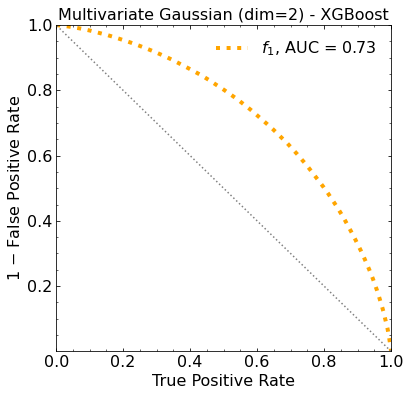


 ########################################

ML iteration  1
[0]	validation_0-logloss:0.67853	validation_1-logloss:0.67891


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[1]	validation_0-logloss:0.66649	validation_1-logloss:0.66731
[2]	validation_0-logloss:0.65658	validation_1-logloss:0.65772
[3]	validation_0-logloss:0.64836	validation_1-logloss:0.64980
[4]	validation_0-logloss:0.64149	validation_1-logloss:0.64326
[5]	validation_0-logloss:0.63578	validation_1-logloss:0.63779
[6]	validation_0-logloss:0.63099	validation_1-logloss:0.63328
[7]	validation_0-logloss:0.62696	validation_1-logloss:0.62947
[8]	validation_0-logloss:0.62355	validation_1-logloss:0.62631
[9]	validation_0-logloss:0.62074	validation_1-logloss:0.62370
[10]	validation_0-logloss:0.61834	validation_1-logloss:0.62150
[11]	validation_0-logloss:0.61633	validation_1-logloss:0.61966
[12]	validation_0-logloss:0.61465	validation_1-logloss:0.61812
[13]	validation_0-logloss:0.61323	validation_1-logloss:0.61686
[14]	validation_0-logloss:0.61202	validation_1-logloss:0.61580
[15]	validation_0-logloss:0.61099	validation_1-logloss:0.61490
[16]	validation_0-logloss:0.61011	validation_1-logloss:0.61421
[

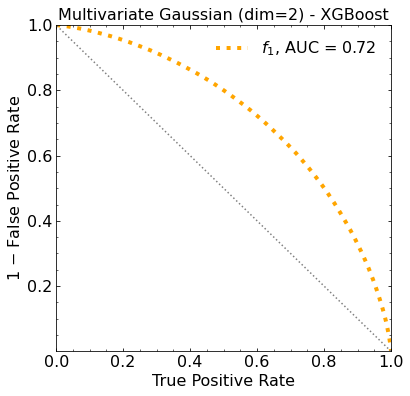


 ########################################

ML iteration  2
[0]	validation_0-logloss:0.67919	validation_1-logloss:0.67924


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[1]	validation_0-logloss:0.66781	validation_1-logloss:0.66780
[2]	validation_0-logloss:0.65838	validation_1-logloss:0.65839
[3]	validation_0-logloss:0.65060	validation_1-logloss:0.65057
[4]	validation_0-logloss:0.64407	validation_1-logloss:0.64409
[5]	validation_0-logloss:0.63868	validation_1-logloss:0.63871
[6]	validation_0-logloss:0.63416	validation_1-logloss:0.63418
[7]	validation_0-logloss:0.63038	validation_1-logloss:0.63044
[8]	validation_0-logloss:0.62720	validation_1-logloss:0.62727
[9]	validation_0-logloss:0.62451	validation_1-logloss:0.62461
[10]	validation_0-logloss:0.62226	validation_1-logloss:0.62239
[11]	validation_0-logloss:0.62037	validation_1-logloss:0.62055
[12]	validation_0-logloss:0.61876	validation_1-logloss:0.61896
[13]	validation_0-logloss:0.61741	validation_1-logloss:0.61764
[14]	validation_0-logloss:0.61627	validation_1-logloss:0.61654
[15]	validation_0-logloss:0.61529	validation_1-logloss:0.61563
[16]	validation_0-logloss:0.61447	validation_1-logloss:0.61484
[

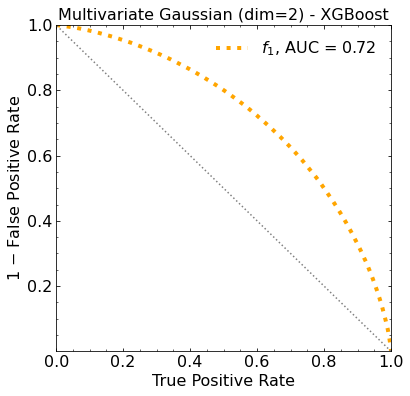


 ########################################

ML iteration  3
[0]	validation_0-logloss:0.67896	validation_1-logloss:0.67910
[1]	validation_0-logloss:0.66737	validation_1-logloss:0.66766
[2]	validation_0-logloss:0.65780	validation_1-logloss:0.65822


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[3]	validation_0-logloss:0.64979	validation_1-logloss:0.65023
[4]	validation_0-logloss:0.64318	validation_1-logloss:0.64372
[5]	validation_0-logloss:0.63765	validation_1-logloss:0.63828
[6]	validation_0-logloss:0.63302	validation_1-logloss:0.63373
[7]	validation_0-logloss:0.62911	validation_1-logloss:0.62988
[8]	validation_0-logloss:0.62585	validation_1-logloss:0.62673
[9]	validation_0-logloss:0.62310	validation_1-logloss:0.62406
[10]	validation_0-logloss:0.62081	validation_1-logloss:0.62190
[11]	validation_0-logloss:0.61887	validation_1-logloss:0.62006
[12]	validation_0-logloss:0.61724	validation_1-logloss:0.61852
[13]	validation_0-logloss:0.61586	validation_1-logloss:0.61719
[14]	validation_0-logloss:0.61468	validation_1-logloss:0.61610
[15]	validation_0-logloss:0.61369	validation_1-logloss:0.61521
[16]	validation_0-logloss:0.61285	validation_1-logloss:0.61448
[17]	validation_0-logloss:0.61212	validation_1-logloss:0.61385
[18]	validation_0-logloss:0.61149	validation_1-logloss:0.61335

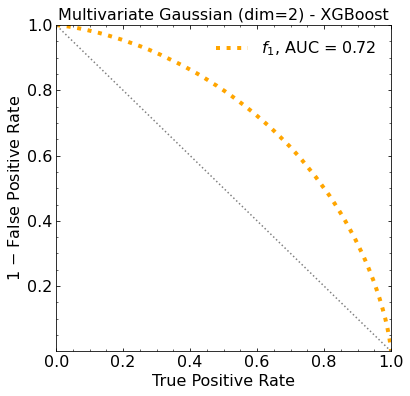


 ########################################

ML iteration  4
[0]	validation_0-logloss:0.67879	validation_1-logloss:0.67900
[1]	validation_0-logloss:0.66701	validation_1-logloss:0.66740
[2]	validation_0-logloss:0.65731	validation_1-logloss:0.65779


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[3]	validation_0-logloss:0.64927	validation_1-logloss:0.64994
[4]	validation_0-logloss:0.64259	validation_1-logloss:0.64339
[5]	validation_0-logloss:0.63699	validation_1-logloss:0.63795
[6]	validation_0-logloss:0.63233	validation_1-logloss:0.63346
[7]	validation_0-logloss:0.62843	validation_1-logloss:0.62967
[8]	validation_0-logloss:0.62514	validation_1-logloss:0.62650
[9]	validation_0-logloss:0.62240	validation_1-logloss:0.62390
[10]	validation_0-logloss:0.62008	validation_1-logloss:0.62169
[11]	validation_0-logloss:0.61811	validation_1-logloss:0.61981
[12]	validation_0-logloss:0.61647	validation_1-logloss:0.61829
[13]	validation_0-logloss:0.61508	validation_1-logloss:0.61704
[14]	validation_0-logloss:0.61387	validation_1-logloss:0.61598
[15]	validation_0-logloss:0.61286	validation_1-logloss:0.61510
[16]	validation_0-logloss:0.61200	validation_1-logloss:0.61436
[17]	validation_0-logloss:0.61126	validation_1-logloss:0.61377
[18]	validation_0-logloss:0.61062	validation_1-logloss:0.61325

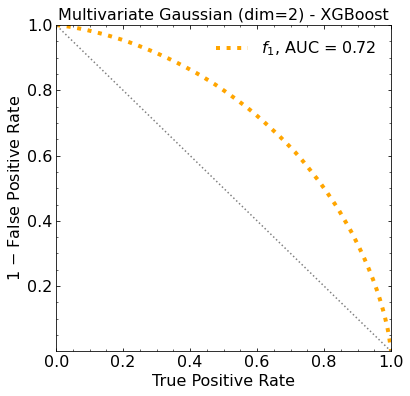


 ########################################

ML iteration  5
[0]	validation_0-logloss:0.67866	validation_1-logloss:0.67893
[1]	validation_0-logloss:0.66686	validation_1-logloss:0.66737
[2]	validation_0-logloss:0.65709	validation_1-logloss:0.65784


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[3]	validation_0-logloss:0.64899	validation_1-logloss:0.64994
[4]	validation_0-logloss:0.64227	validation_1-logloss:0.64338
[5]	validation_0-logloss:0.63667	validation_1-logloss:0.63798
[6]	validation_0-logloss:0.63196	validation_1-logloss:0.63342
[7]	validation_0-logloss:0.62802	validation_1-logloss:0.62961
[8]	validation_0-logloss:0.62469	validation_1-logloss:0.62646
[9]	validation_0-logloss:0.62190	validation_1-logloss:0.62379
[10]	validation_0-logloss:0.61955	validation_1-logloss:0.62159
[11]	validation_0-logloss:0.61759	validation_1-logloss:0.61974
[12]	validation_0-logloss:0.61591	validation_1-logloss:0.61817
[13]	validation_0-logloss:0.61451	validation_1-logloss:0.61692
[14]	validation_0-logloss:0.61331	validation_1-logloss:0.61585
[15]	validation_0-logloss:0.61229	validation_1-logloss:0.61495
[16]	validation_0-logloss:0.61143	validation_1-logloss:0.61422
[17]	validation_0-logloss:0.61067	validation_1-logloss:0.61361
[18]	validation_0-logloss:0.61002	validation_1-logloss:0.61311

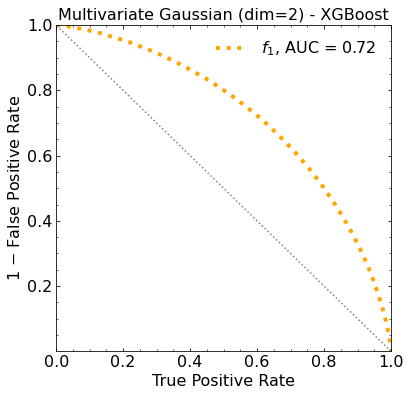


 ########################################

ML iteration  6
[0]	validation_0-logloss:0.67881	validation_1-logloss:0.67890
[1]	validation_0-logloss:0.66708	validation_1-logloss:0.66742


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[2]	validation_0-logloss:0.65744	validation_1-logloss:0.65797
[3]	validation_0-logloss:0.64946	validation_1-logloss:0.65019
[4]	validation_0-logloss:0.64277	validation_1-logloss:0.64357
[5]	validation_0-logloss:0.63720	validation_1-logloss:0.63816
[6]	validation_0-logloss:0.63252	validation_1-logloss:0.63359
[7]	validation_0-logloss:0.62863	validation_1-logloss:0.62982
[8]	validation_0-logloss:0.62536	validation_1-logloss:0.62664
[9]	validation_0-logloss:0.62260	validation_1-logloss:0.62403
[10]	validation_0-logloss:0.62027	validation_1-logloss:0.62179
[11]	validation_0-logloss:0.61834	validation_1-logloss:0.61999
[12]	validation_0-logloss:0.61668	validation_1-logloss:0.61843
[13]	validation_0-logloss:0.61529	validation_1-logloss:0.61715
[14]	validation_0-logloss:0.61410	validation_1-logloss:0.61608
[15]	validation_0-logloss:0.61310	validation_1-logloss:0.61517
[16]	validation_0-logloss:0.61225	validation_1-logloss:0.61440
[17]	validation_0-logloss:0.61150	validation_1-logloss:0.61381


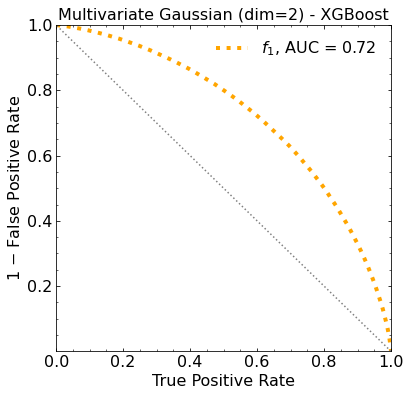


 ########################################

ML iteration  7
[0]	validation_0-logloss:0.67856	validation_1-logloss:0.67893


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[1]	validation_0-logloss:0.66659	validation_1-logloss:0.66734
[2]	validation_0-logloss:0.65673	validation_1-logloss:0.65773
[3]	validation_0-logloss:0.64851	validation_1-logloss:0.64981
[4]	validation_0-logloss:0.64169	validation_1-logloss:0.64323
[5]	validation_0-logloss:0.63600	validation_1-logloss:0.63774
[6]	validation_0-logloss:0.63126	validation_1-logloss:0.63329
[7]	validation_0-logloss:0.62723	validation_1-logloss:0.62947
[8]	validation_0-logloss:0.62389	validation_1-logloss:0.62633
[9]	validation_0-logloss:0.62104	validation_1-logloss:0.62366
[10]	validation_0-logloss:0.61866	validation_1-logloss:0.62145
[11]	validation_0-logloss:0.61665	validation_1-logloss:0.61960
[12]	validation_0-logloss:0.61492	validation_1-logloss:0.61805
[13]	validation_0-logloss:0.61346	validation_1-logloss:0.61678
[14]	validation_0-logloss:0.61223	validation_1-logloss:0.61571
[15]	validation_0-logloss:0.61120	validation_1-logloss:0.61482
[16]	validation_0-logloss:0.61031	validation_1-logloss:0.61409
[

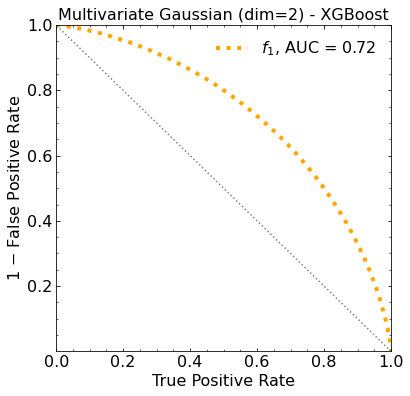


 ########################################

ML iteration  8
[0]	validation_0-logloss:0.67862	validation_1-logloss:0.67897
[1]	validation_0-logloss:0.66676	validation_1-logloss:0.66741


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[2]	validation_0-logloss:0.65695	validation_1-logloss:0.65783
[3]	validation_0-logloss:0.64886	validation_1-logloss:0.64993
[4]	validation_0-logloss:0.64207	validation_1-logloss:0.64339
[5]	validation_0-logloss:0.63642	validation_1-logloss:0.63798
[6]	validation_0-logloss:0.63169	validation_1-logloss:0.63343
[7]	validation_0-logloss:0.62774	validation_1-logloss:0.62965
[8]	validation_0-logloss:0.62438	validation_1-logloss:0.62645
[9]	validation_0-logloss:0.62157	validation_1-logloss:0.62379
[10]	validation_0-logloss:0.61920	validation_1-logloss:0.62155
[11]	validation_0-logloss:0.61719	validation_1-logloss:0.61973
[12]	validation_0-logloss:0.61552	validation_1-logloss:0.61822
[13]	validation_0-logloss:0.61409	validation_1-logloss:0.61693
[14]	validation_0-logloss:0.61287	validation_1-logloss:0.61586
[15]	validation_0-logloss:0.61184	validation_1-logloss:0.61498
[16]	validation_0-logloss:0.61094	validation_1-logloss:0.61424
[17]	validation_0-logloss:0.61018	validation_1-logloss:0.61361


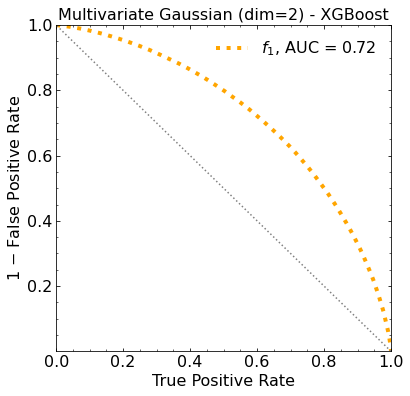


 ########################################

ML iteration  9
[0]	validation_0-logloss:0.67867	validation_1-logloss:0.67892
[1]	validation_0-logloss:0.66683	validation_1-logloss:0.66737


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[2]	validation_0-logloss:0.65704	validation_1-logloss:0.65783
[3]	validation_0-logloss:0.64894	validation_1-logloss:0.64994
[4]	validation_0-logloss:0.64219	validation_1-logloss:0.64338
[5]	validation_0-logloss:0.63656	validation_1-logloss:0.63794
[6]	validation_0-logloss:0.63183	validation_1-logloss:0.63342
[7]	validation_0-logloss:0.62787	validation_1-logloss:0.62957
[8]	validation_0-logloss:0.62454	validation_1-logloss:0.62640
[9]	validation_0-logloss:0.62177	validation_1-logloss:0.62378
[10]	validation_0-logloss:0.61943	validation_1-logloss:0.62160
[11]	validation_0-logloss:0.61744	validation_1-logloss:0.61976
[12]	validation_0-logloss:0.61576	validation_1-logloss:0.61823
[13]	validation_0-logloss:0.61434	validation_1-logloss:0.61694
[14]	validation_0-logloss:0.61313	validation_1-logloss:0.61587
[15]	validation_0-logloss:0.61212	validation_1-logloss:0.61499
[16]	validation_0-logloss:0.61125	validation_1-logloss:0.61427
[17]	validation_0-logloss:0.61050	validation_1-logloss:0.61366


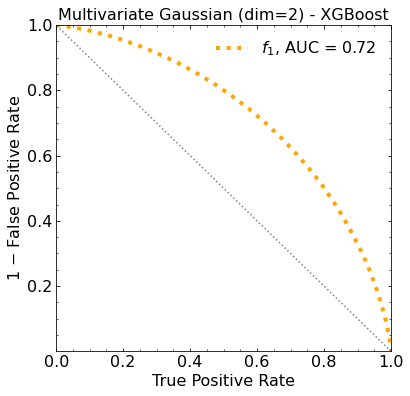


 ########################################



In [68]:
iterations_ML = 10

print('ML iteration 1')

# CLASSIFIER
classifier = XGBClassifier(
    n_estimators=500,
    learning_rate=0.1,
    reg_lambda=0.0,reg_alpha=0.0,
    gamma=0.0,objective='binary:logistic',
    max_depth=5)

# FIT
classifier.fit(X_gauss_train[:100000],Y_gauss_train[:100000],eval_set=[(X_gauss_train[:100000], Y_gauss_train[:100000]), (X_gauss_val, Y_gauss_val)],
        eval_metric='logloss',early_stopping_rounds=50,#early stopping
        verbose=True)

# PREDICTIONS
y_pred_xg_aux = classifier.predict_proba(X_gauss_val).T[1]
y_pred_xg_auxRE = np.reshape(y_pred_xg_aux, (1,len(y_pred_xg_aux)))


# ROC
fpr_gauss_xg, tpr_gauss_xg, _ = roc_curve(Y_gauss_val, y_pred_xg_aux)
roc_auc_xg = auc(fpr_gauss_xg, tpr_gauss_xg)


# PLOT THE ROC WITH AUC
fig = plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax0.minorticks_on()


plt.plot(tpr_gauss_xg,1-fpr_gauss_xg,label="$f_{1}$, AUC = %0.2f" % roc_auc_xg,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.title(r"Multivariate Gaussian (dim=2) - XGBoost",fontsize=16)
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()

print('\n ########################################\n')





for it in range(1,iterations_ML):

    print('ML iteration ', it)
    
    # CLASSIFIER
    classifier = XGBClassifier(
        n_estimators=500,
        learning_rate=0.1,
        reg_lambda=0.0,reg_alpha=0.0,
        gamma=0.0,objective='binary:logistic',
        max_depth=5)

    # FIT
    classifier.fit(X_gauss_train[(100000*it):(100000*it)+100000],Y_gauss_train[(100000*it):(100000*it)+100000],eval_set=[(X_gauss_train[(100000*it):(100000*it)+100000], Y_gauss_train[(100000*it):(100000*it)+100000]), (X_gauss_val, Y_gauss_val)],
            eval_metric='logloss',early_stopping_rounds=50,#early stopping
            verbose=True)

    # PREDICTIONS
    y_pred_xg_aux_it = classifier.predict_proba(X_gauss_test).T[1]
    y_pred_xg_auxRE_it = np.reshape(y_pred_xg_aux_it, (1,len(y_pred_xg_aux_it)))
    
    y_pred_xg_auxRE = np.concatenate([y_pred_xg_auxRE,y_pred_xg_auxRE_it])


    # ROC
    fpr_gauss_xg, tpr_gauss_xg, _ = roc_curve(Y_gauss_test, y_pred_xg_aux_it)
    roc_auc_xg = auc(fpr_gauss_xg, tpr_gauss_xg)


    # PLOT THE ROC WITH AUC
    fig = plt.figure(figsize=(6, 6))
    gs = gridspec.GridSpec(1, 1) 
    ax0 = plt.subplot(gs[0])
    ax0.yaxis.set_ticks_position('both')
    ax0.xaxis.set_ticks_position('both')
    ax0.tick_params(direction="in",which="both")
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    ax0.minorticks_on()


    plt.plot(tpr_gauss_xg,1-fpr_gauss_xg,label="$f_{1}$, AUC = %0.2f" % roc_auc_xg,color="orange",ls=":",lw=4)
    plt.plot([1,0],[0,1],ls=":",color="grey")
    plt.xlabel("True Positive Rate",fontsize=16)
    plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
    plt.legend()
    plt.title(r"Multivariate Gaussian (dim=2) - XGBoost",fontsize=16)
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.yticks([0.2,0.4,0.6,0.8,1.])
    plt.legend(frameon=False,fontsize=16)
    plt.show()
    
    print('\n ########################################\n')
    
    
y_pred_xg = np.mean(y_pred_xg_auxRE, axis=0)

Classification score (1ML):


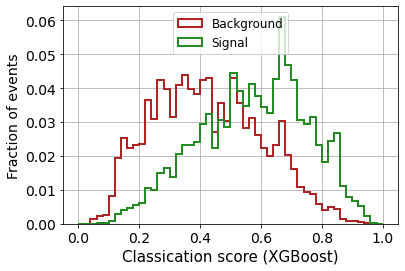

Classification score (10ML):


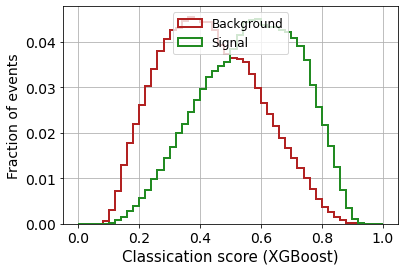

In [69]:
########################
# CLASSIFICATION SCORE #
########################

# Outputs for testidation data set

pred_XG_SM_1ML = []
pred_XG_NP_1ML = []

for i in range(len(Y_gauss_test)):
    if Y_gauss_test[i] == 0:
        pred_XG_SM_1ML.append(y_pred_xg_1ML[i])
    else:
        pred_XG_NP_1ML.append(y_pred_xg_1ML[i])
        
        
print('Classification score (1ML):')
        
weights = np.ones_like(pred_XG_SM_1ML)/float(len(pred_XG_SM_1ML))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM_1ML, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP_1ML)/float(len(pred_XG_NP_1ML))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP_1ML, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12, loc="upper center")
#plt.title('Multivariate Gaussian distributions, $\mathcal{N}_{2}$', fontsize=14)
#plt.savefig('images/' + '2gaussian-output.pdf', format="pdf", bbox_inches="tight")
plt.show()




# Outputs for testidation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(Y_gauss_test)):
    if Y_gauss_test[i] == 0:
        pred_XG_SM.append(y_pred_xg[i])
    else:
        pred_XG_NP.append(y_pred_xg[i])
        
        
print('Classification score (10ML):')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12, loc="upper center")
#plt.title('Multivariate Gaussian distributions, $\mathcal{N}_{2}$', fontsize=14)
#plt.savefig('images/' + '2gaussian-output.pdf', format="pdf", bbox_inches="tight")
plt.show()


#### Compare with optimal limit (we have the true pdfs for this example, gaussians)

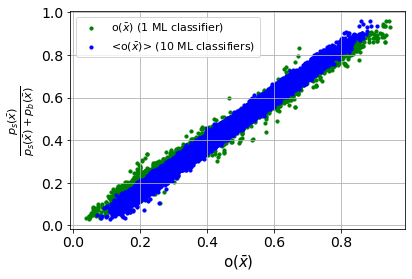

In [70]:
ratio_ps_pb_true = sig_multi.pdf(X_gauss_test) / ( sig_multi.pdf(X_gauss_test) + bkg_multi.pdf(X_gauss_test) )

ratio_ps_pb_true_B = sig_multi.pdf(X_gauss_test_SM) / ( sig_multi.pdf(X_gauss_test_SM) + bkg_multi.pdf(X_gauss_test_SM) )
ratio_ps_pb_true_S = sig_multi.pdf(X_gauss_test_NP) / ( sig_multi.pdf(X_gauss_test_NP) + bkg_multi.pdf(X_gauss_test_NP) )


plt.scatter(y_pred_xg_1ML[:10000], ratio_ps_pb_true[:10000], color='green', label=r'o($\bar{x}$) (1 ML classifier)', s=10)
plt.scatter(y_pred_xg[:10000], ratio_ps_pb_true[:10000], color='blue', label=r'<o($\bar{x}$)> (10 ML classifiers)', s=10)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel(r"o($\bar{x}$)",fontsize=15)
plt.ylabel(r"$\frac{p_s(\bar{x})}{p_s(\bar{x})+p_b(\bar{x})}$",fontsize=16)
plt.grid()
plt.legend(fontsize=11)
#plt.savefig('images/' + 'optimalclass-vs-ox-comparison.pdf', format="pdf", bbox_inches="tight")
plt.show()

###### Example of ensemble

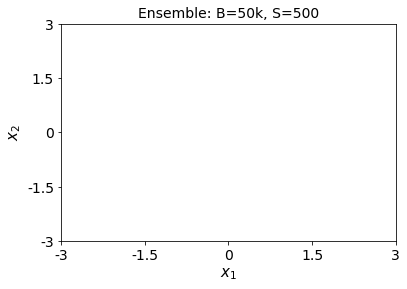

In [43]:
# Plot 1 ensemble with B=50k events and S=500 events
# how an experiment would look like for a measurement of B=50k and S=500 including binning

hist, xbins, ybins = np.histogram2d(np.concatenate([X_gauss_val_SM[:50000],X_gauss_val_NP[:500]])[:,1], np.concatenate([X_gauss_val_SM[:50000],X_gauss_val_NP[:500]])[:,0], bins=(10, 10), range = [[-3,3],[-3,3]])

im = plt.imshow(hist,interpolation='none')
plt.gca().invert_yaxis() 
cbar = plt.colorbar()
cbar.ax.set_ylabel('Number of events', rotation=270, fontsize=14)
cbar.ax.get_yaxis().labelpad = 17
cbar.ax.tick_params(labelsize=12)

ax = plt.subplot(111)
bins_labelsx = [-0.5,2,4.5,7,9.5]
namesx = ['-3','-1.5','0','1.5','3']
ax.set_xticks(bins_labelsx)
ax.set_xticklabels(namesx)
bins_labelsy = [-0.5,2,4.5,7,9.5]
namesy = ['-3','-1.5','0','1.5','3']
ax.set_yticks(bins_labelsy)
ax.set_yticklabels(namesy)
plt.xlabel('$x_1$',fontsize=15)
plt.ylabel('$x_2$',fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Ensemble: B=50k, S=500', fontsize=14)
#plt.savefig('images/' + '2gaussian-ensemble-example.pdf', format="pdf", bbox_inches="tight")
plt.show()

## METHODS to calculate Z

### 1. BINNED POISSON LOG-LIKELIHOOD

#### 1.1 Binning the original parameter space, in this case 2-dimensional (x_1,x_2)

In [71]:
#################################
# BINNED POISSON LOG-LIKELIHOOD #
#################################


store_Z_bins = []


for iii in range(len(SB_ratio)):

    print('B_expected: ', B_expected)
    print('S_expected: ', S_expected[iii])
    print(r'S/$\sqrt{B}$: ', SsqrtB[iii])

    # Les't use an integer number of possible ensembles
    N_ensembles_back = int(N / B_expected)
    N_events_back = N_ensembles_back * B_expected

    N_ensembles_sig = int(N / S_expected[iii])
    N_events_sig = N_ensembles_sig * S_expected[iii]


    #Let's find out the expected number of B and S events in each bin:

    # bin the parameter space of all background events
    hist_back, binedges_back = np.histogramdd([background_X_1[:N_events_back],background_X_2[:N_events_back]], bins=(10,10), range = [[-3,3],[-3,3]])
    # now divide by the number of possible ensembles
    back_prom = hist_back.T.ravel()/N_ensembles_back

    # same for signal
    hist_sig, binedges_sig = np.histogramdd([signal_X_1[:N_events_sig],signal_X_2[:N_events_sig]], bins=(10,10), range = [[-3,3],[-3,3]])
    sig_prom = hist_sig.T.ravel()/N_ensembles_sig

        

    # If a bins has no expected background events replace that zero for the minimum B_bin=/=0

    # find the minimum
    back_prom_noceros = []
    for i in range(len(back_prom)):
        if back_prom[i]!=0:
            back_prom_noceros.append(back_prom[i])

    min_back = min(back_prom_noceros)

    # replace the zeros
    for i in range(len(back_prom)):
        if back_prom[i]==0:
            back_prom[i] = min_back

    # then the signif Z^binned-Asimov:
    Z_bins = ( 2* sum( ( back_prom * np.log( back_prom/(sig_prom + back_prom) ) ) + sig_prom ) )**0.5

    store_Z_bins.append(Z_bins)

    print('Z_bins : ', Z_bins)
    
    print('\n ----------------------------------- \n')


B_expected:  50000
S_expected:  50
S/$\sqrt{B}$:  0.22360679774997896
Z_bins :  0.31268965303709423

 ----------------------------------- 

B_expected:  50000
S_expected:  125
S/$\sqrt{B}$:  0.5590169943749475
Z_bins :  0.7802510576974989

 ----------------------------------- 

B_expected:  50000
S_expected:  250
S/$\sqrt{B}$:  1.118033988749895
Z_bins :  1.55567578569005

 ----------------------------------- 

B_expected:  50000
S_expected:  375
S/$\sqrt{B}$:  1.6770509831248424
Z_bins :  2.3263408397919165

 ----------------------------------- 

B_expected:  50000
S_expected:  500
S/$\sqrt{B}$:  2.23606797749979
Z_bins :  3.0926340062365276

 ----------------------------------- 

B_expected:  50000
S_expected:  1250
S/$\sqrt{B}$:  5.5901699437494745
Z_bins :  7.601299500631015

 ----------------------------------- 

B_expected:  50000
S_expected:  2500
S/$\sqrt{B}$:  11.180339887498949
Z_bins :  14.820450619938207

 ----------------------------------- 

B_expected:  50000
S_expected:

In [72]:
print(store_Z_bins)

[0.31268965303709423, 0.7802510576974989, 1.55567578569005, 2.3263408397919165, 3.0926340062365276, 7.601299500631015, 14.820450619938207, 21.7294163424833]


In [10]:
# To use if you dont want to run everything again. Its the previous results
store_Z_bins = [0.31199826845231765, 0.7785596745814348, 1.552413117942453, 2.3216631237513727, 3.086561945720133, 7.588997423494545, 14.802687598210081, 21.70996735334155]

<ipython-input-73-efe06d4e6527>:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-ok" (-> color='k'). The keyword argument will take precedence.
  plt.plot(posX, store_Z_bins, '-ok', color='dodgerblue', lw=lw, label=r'$\bar{x}$ BL (10 l.bins)')


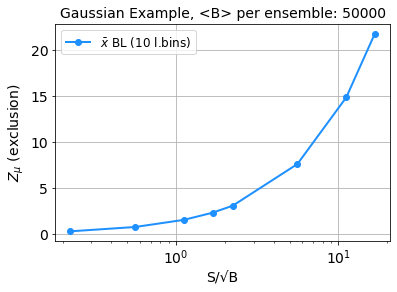

In [73]:
#########
# PLOTS #
#########

posX = []

for i in range(len(SB_ratio)):
    posX.append( (B_expected*SB_ratio[i]) / ( B_expected )**0.5 )


    
plt.figure()
lw = 2

plt.plot(posX, store_Z_bins, '-ok', color='dodgerblue', lw=lw, label=r'$\bar{x}$ BL (10 l.bins)') 

#plt.xlim([0.5, 10])
#plt.ylim([-0.5, 7.5])
plt.xscale('log')
plt.xlabel('S/√B', fontsize=14)
plt.ylabel('$Z_{\mu}$ (exclusion)', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.title('Gaussian Example, <B> per ensemble: %0.2d' % B_expected, fontsize=14)
plt.legend(loc="upper left", fontsize=12)
plt.show()

#### 1.2 Binning the classifier output, always a 1-dimensional space

In [74]:
#################################
# BINNED POISSON LOG-LIKELIHOOD #
#################################


store_Z_bins_class = []
store_Z_bins_class_1ML = []

store_Z_bins_class_eq = []
store_Z_bins_class_eq_1ML = []


for iii in range(len(SB_ratio)):

    print('B_expected: ', B_expected)
    print('S_expected: ', S_expected[iii])
    print(r'S/$\sqrt{B}$: ', SsqrtB[iii])

    
    ########################
    # 10 ML linear binning #
    ########################
    # Les't use an integer number of possible ensembles
    N_ensembles_back = int(len(pred_XG_SM) / B_expected)
    N_events_back = N_ensembles_back * B_expected

    N_ensembles_sig = int(len(pred_XG_NP) / S_expected[iii])
    N_events_sig = N_ensembles_sig * S_expected[iii]


    #Let's find out the expected number of B and S events in each bin:

    # bin the parameter space of all background events
    hist_back, binedges_back = np.histogramdd([pred_XG_SM[:N_events_back]], bins=(10), range = [[0,1]])
    # now divide by the number of possible ensembles
    back_prom = hist_back.T.ravel()/N_ensembles_back

    # same for signal
    hist_sig, binedges_sig = np.histogramdd([pred_XG_NP[:N_events_sig]], bins=(10), range = [[0,1]])
    sig_prom = hist_sig.T.ravel()/N_ensembles_sig

        

    # If a bins has no expected background events replace that zero for the minimum B_bin=/=0

    # find the minimum
    back_prom_noceros = []
    for i in range(len(back_prom)):
        if back_prom[i]!=0:
            back_prom_noceros.append(back_prom[i])

    min_back = min(back_prom_noceros)

    # replace the zeros
    for i in range(len(back_prom)):
        if back_prom[i]==0:
            back_prom[i] = min_back

    # then the signif Z^binned-Asimov:
    Z_bins = ( 2* sum( ( back_prom * np.log( back_prom/(sig_prom + back_prom) ) ) + sig_prom ) )**0.5

    store_Z_bins_class.append(Z_bins)

    print('Z_bins : ', Z_bins)
    
    
    
    ########################
    # 1 ML  linear binning #
    ########################
    # Les't use an integer number of possible ensembles
    N_ensembles_back = int(len(pred_XG_SM_1ML) / B_expected)
    N_events_back = N_ensembles_back * B_expected

    N_ensembles_sig = int(len(pred_XG_NP_1ML) / S_expected[iii])
    N_events_sig = N_ensembles_sig * S_expected[iii]


    #Let's find out the expected number of B and S events in each bin:

    # bin the parameter space of all background events
    hist_back, binedges_back = np.histogramdd([pred_XG_SM_1ML[:N_events_back]], bins=(10), range = [[0,1]])
    # now divide by the number of possible ensembles
    back_prom = hist_back.T.ravel()/N_ensembles_back

    # same for signal
    hist_sig, binedges_sig = np.histogramdd([pred_XG_NP_1ML[:N_events_sig]], bins=(10), range = [[0,1]])
    sig_prom = hist_sig.T.ravel()/N_ensembles_sig

        

    # If a bins has no expected background events replace that zero for the minimum B_bin=/=0

    # find the minimum
    back_prom_noceros = []
    for i in range(len(back_prom)):
        if back_prom[i]!=0:
            back_prom_noceros.append(back_prom[i])

    min_back = min(back_prom_noceros)

    # replace the zeros
    for i in range(len(back_prom)):
        if back_prom[i]==0:
            back_prom[i] = min_back

    # then the signif Z^binned-Asimov:
    Z_bins_1ML = ( 2* sum( ( back_prom * np.log( back_prom/(sig_prom + back_prom) ) ) + sig_prom ) )**0.5

    store_Z_bins_class_1ML.append(Z_bins_1ML)

    print('Z_bins_1ML : ', Z_bins_1ML)
    
    
    
    ############################
    # 10 ML non linear binning #
    ############################
    # Les't use an integer number of possible ensembles
    N_ensembles_back = int(len(pred_XG_SM) / B_expected)
    N_events_back = N_ensembles_back * B_expected

    N_ensembles_sig = int(len(pred_XG_NP) / S_expected[iii])
    N_events_sig = N_ensembles_sig * S_expected[iii]


    #Let's find out the expected number of B and S events in each bin:
    # same number of B events per bin
    bin_edges_same = pd.qcut(pd.DataFrame(pred_XG_SM[:N_events_back])[0], q = 10, precision=0, retbins = True)[1]

    # bin the parameter space of all background events
    hist_back, binedges_back = np.histogramdd([pred_XG_SM[:N_events_back]], bins=[bin_edges_same], range = [[0,1]])
    # now divide by the number of possible ensembles
    back_prom = hist_back.T.ravel()/N_ensembles_back

    # same for signal
    hist_sig, binedges_sig = np.histogramdd([pred_XG_NP[:N_events_sig]], bins=[bin_edges_same], range = [[0,1]])
    sig_prom = hist_sig.T.ravel()/N_ensembles_sig

        

    # If a bins has no expected background events replace that zero for the minimum B_bin=/=0

    # find the minimum
    back_prom_noceros = []
    for i in range(len(back_prom)):
        if back_prom[i]!=0:
            back_prom_noceros.append(back_prom[i])

    min_back = min(back_prom_noceros)

    # replace the zeros
    for i in range(len(back_prom)):
        if back_prom[i]==0:
            back_prom[i] = min_back

    # then the signif Z^binned-Asimov:
    Z_bins_eq = ( 2* sum( ( back_prom * np.log( back_prom/(sig_prom + back_prom) ) ) + sig_prom ) )**0.5

    store_Z_bins_class_eq.append(Z_bins_eq)

    print('Z_bins_eq : ', Z_bins_eq)
    
    
    
    ############################
    # 1 ML  non linear binning #
    ############################
    # Les't use an integer number of possible ensembles
    N_ensembles_back = int(len(pred_XG_SM_1ML) / B_expected)
    N_events_back = N_ensembles_back * B_expected

    N_ensembles_sig = int(len(pred_XG_NP_1ML) / S_expected[iii])
    N_events_sig = N_ensembles_sig * S_expected[iii]


    #Let's find out the expected number of B and S events in each bin:
    # same number of B events per bin
    bin_edges_same = pd.qcut(pd.DataFrame(pred_XG_SM_1ML[:N_events_back])[0], q = 10, precision=0, retbins = True)[1]

    # bin the parameter space of all background events
    hist_back, binedges_back = np.histogramdd([pred_XG_SM_1ML[:N_events_back]], bins=[bin_edges_same], range = [[0,1]])
    # now divide by the number of possible ensembles
    back_prom = hist_back.T.ravel()/N_ensembles_back

    # same for signal
    hist_sig, binedges_sig = np.histogramdd([pred_XG_NP_1ML[:N_events_sig]], bins=[bin_edges_same], range = [[0,1]])
    sig_prom = hist_sig.T.ravel()/N_ensembles_sig

        

    # If a bins has no expected background events replace that zero for the minimum B_bin=/=0

    # find the minimum
    back_prom_noceros = []
    for i in range(len(back_prom)):
        if back_prom[i]!=0:
            back_prom_noceros.append(back_prom[i])

    min_back = min(back_prom_noceros)

    # replace the zeros
    for i in range(len(back_prom)):
        if back_prom[i]==0:
            back_prom[i] = min_back

    # then the signif Z^binned-Asimov:
    Z_bins_eq_1ML = ( 2* sum( ( back_prom * np.log( back_prom/(sig_prom + back_prom) ) ) + sig_prom ) )**0.5

    store_Z_bins_class_eq_1ML.append(Z_bins_eq_1ML)

    print('Z_bins_eq_1ML : ', Z_bins_eq_1ML)
    
    print('\n ----------------------------------- \n')


B_expected:  50000
S_expected:  50
S/$\sqrt{B}$:  0.22360679774997896
Z_bins :  0.3113308184745419
Z_bins_1ML :  0.3120245330892549
Z_bins_eq :  0.2985307921984469
Z_bins_eq_1ML :  0.298249467270319

 ----------------------------------- 

B_expected:  50000
S_expected:  125
S/$\sqrt{B}$:  0.5590169943749475
Z_bins :  0.7770168060148157
Z_bins_1ML :  0.7787319587006652
Z_bins_eq :  0.7453924276388357
Z_bins_eq_1ML :  0.744693638897005

 ----------------------------------- 

B_expected:  50000
S_expected:  250
S/$\sqrt{B}$:  1.118033988749895
Z_bins :  1.5497200085298748
Z_bins_1ML :  1.5530888251050654
Z_bins_eq :  1.4876916989198827
Z_bins_eq_1ML :  1.486308996266369

 ----------------------------------- 

B_expected:  50000
S_expected:  375
S/$\sqrt{B}$:  1.6770509831248424
Z_bins :  2.318254613389126
Z_bins_1ML :  2.3232306544958763
Z_bins_eq :  2.2269750821104366
Z_bins_eq_1ML :  2.224919131315952

 ----------------------------------- 

B_expected:  50000
S_expected:  500
S/$\sqrt{B

In [75]:
print(store_Z_bins_class)
print(store_Z_bins_class_1ML)
print(store_Z_bins_class_eq)
print(store_Z_bins_class_eq_1ML)

[0.3113308184745419, 0.7770168060148157, 1.5497200085298748, 2.318254613389126, 3.082573341450515, 7.586973390386791, 14.81510859290643, 21.74378799907666]
[0.3120245330892549, 0.7787319587006652, 1.5530888251050654, 2.3232306544958763, 3.0890807533017606, 7.601771599744631, 14.840987556412669, 21.77825837216223]
[0.2985307921984469, 0.7453924276388357, 1.4876916989198827, 2.2269750821104366, 2.9631726390243935, 7.31943341823408, 14.362575895990986, 21.160460085308234]
[0.298249467270319, 0.744693638897005, 1.486308996266369, 2.224919131315952, 2.9604652479490365, 7.313072358075101, 14.351050547918069, 21.14490002606763]


In [8]:
# To use if you dont want to run everything again. Its the previous results
store_Z_bins_class = [0.31627304451623095, 0.7891861568915056, 1.5735189406312795, 2.353032464084265, 3.128054778089691, 7.687921737335137, 14.987550491961661, 21.970818376191346]

In [ ]:
# To use if you dont want to run everything again. Its the previous results
store_Z_bins_class = [0.3113308184745419, 0.7770168060148157, 1.5497200085298748, 2.318254613389126, 3.082573341450515, 7.586973390386791, 14.81510859290643, 21.74378799907666]
store_Z_bins_class_1ML = [0.3120245330892549, 0.7787319587006652, 1.5530888251050654, 2.3232306544958763, 3.0890807533017606, 7.601771599744631, 14.840987556412669, 21.77825837216223]
store_Z_bins_class_eq = [0.2985307921984469, 0.7453924276388357, 1.4876916989198827, 2.2269750821104366, 2.9631726390243935, 7.31943341823408, 14.362575895990986, 21.160460085308234]
store_Z_bins_class_eq_1ML = [0.298249467270319, 0.744693638897005, 1.486308996266369, 2.224919131315952, 2.9604652479490365, 7.313072358075101, 14.351050547918069, 21.14490002606763]

<ipython-input-76-692e38f5dc74>:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-ok" (-> color='k'). The keyword argument will take precedence.
  plt.plot(posX, store_Z_bins, '-ok', color='dodgerblue', lw=lw, label=r'$\bar{x}$ BL (10 l.bins)')
<ipython-input-76-692e38f5dc74>:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-ok" (-> color='k'). The keyword argument will take precedence.
  plt.plot(posX, store_Z_bins_class, '-ok', color='blue', lw=lw, label=r'$o(\bar{x})$ BL (10 l.bins) (10ML)')
<ipython-input-76-692e38f5dc74>:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-ok" (-> color='k'). The keyword argument will take precedence.
  plt.plot(posX, store_Z_bins_class_1ML, '-ok', color='green', lw=lw, label=r'$o(\bar{x})$ BL (10 l.bins) (1ML)')
<ipython-input-76-692e38f5dc74>:18: UserWarning: color is redundantly defined by the 'color' k

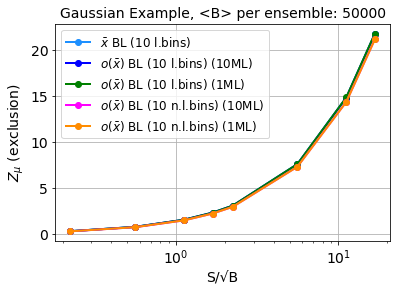

In [76]:
#########
# PLOTS #
#########

posX = []

for i in range(len(SB_ratio)):
    posX.append( (B_expected*SB_ratio[i]) / ( B_expected )**0.5 )


    
plt.figure()
lw = 2

plt.plot(posX, store_Z_bins, '-ok', color='dodgerblue', lw=lw, label=r'$\bar{x}$ BL (10 l.bins)') 
plt.plot(posX, store_Z_bins_class, '-ok', color='blue', lw=lw, label=r'$o(\bar{x})$ BL (10 l.bins) (10ML)') 
plt.plot(posX, store_Z_bins_class_1ML, '-ok', color='green', lw=lw, label=r'$o(\bar{x})$ BL (10 l.bins) (1ML)') 
plt.plot(posX, store_Z_bins_class_eq, '-ok', color='magenta', lw=lw, label=r'$o(\bar{x})$ BL (10 n.l.bins) (10ML)') 
plt.plot(posX, store_Z_bins_class_eq_1ML, '-ok', color='darkorange', lw=lw, label=r'$o(\bar{x})$ BL (10 n.l.bins) (1ML)') 

#plt.xlim([0.5, 10])
#plt.ylim([-0.5, 7.5])
plt.xscale('log')
plt.xlabel('S/√B', fontsize=14)
plt.ylabel('$Z_{\mu}$ (exclusion)', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.title('Gaussian Example, <B> per ensemble: %0.2d' % B_expected, fontsize=14)
plt.legend(loc="upper left", fontsize=12)
plt.show()

### 2. TRUE PDF LIKELIHOOD (GAUSSIANS)

B_expected:  50000
S_expected:  50
S/$\sqrt{B}$:  0.22360679774997896
n_ensembles (initial):  5000

 If  10010  =  855    then the proposed range has to be extended
n_ensembles (actual):  4255
This may take long...


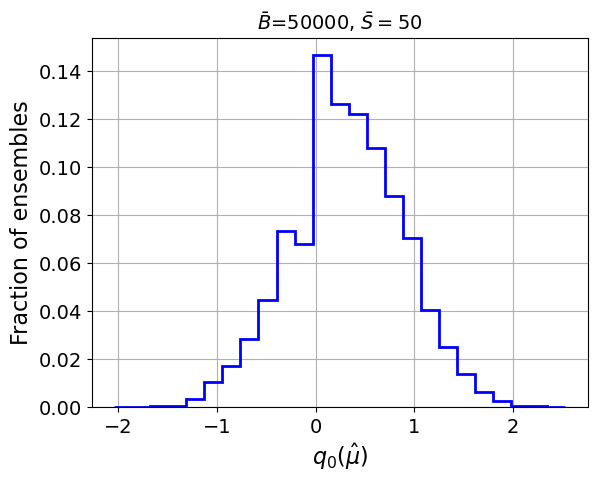

muhat mean:  0.0500822561692127
median q_muhat:  0.305891501848933
Z_gaussian:  0.55307458976971

 ------------------------------------ 

B_expected:  50000
S_expected:  125
S/$\sqrt{B}$:  0.5590169943749475
n_ensembles (initial):  5000

 If  10025  =  856    then the proposed range has to be extended
n_ensembles (actual):  4256
This may take long...


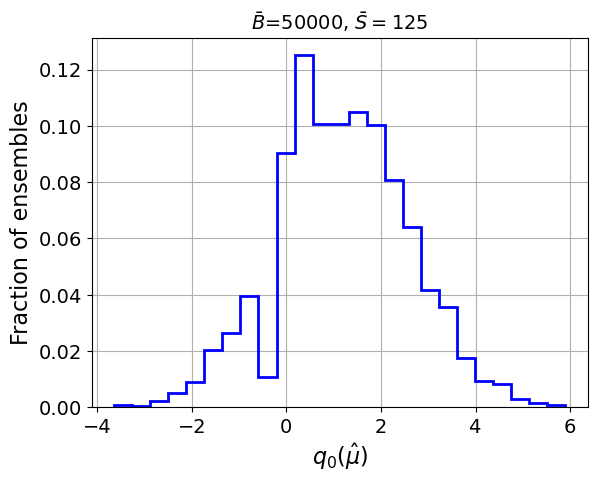

muhat mean:  0.10855263157894737
median q_muhat:  1.1777473994332013
Z_gaussian:  1.0852407103648487

 ------------------------------------ 

B_expected:  50000
S_expected:  250
S/$\sqrt{B}$:  1.118033988749895
n_ensembles (initial):  5000

 If  10050  =  856    then the proposed range has to be extended
n_ensembles (actual):  4254
This may take long...


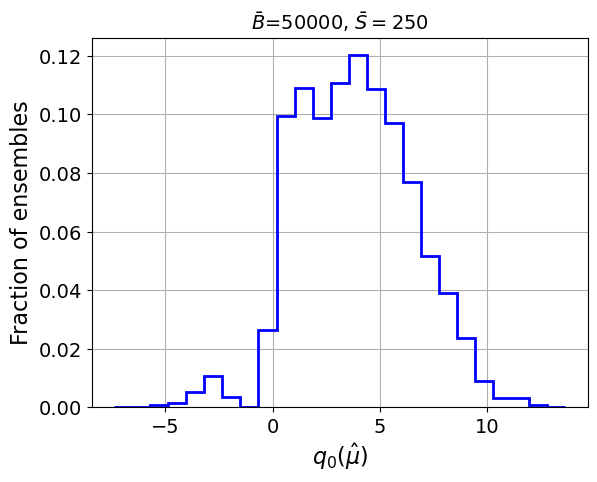

muhat mean:  0.12226140103432068
median q_muhat:  3.8095419852656107
Z_gaussian:  1.951804802039797

 ------------------------------------ 

B_expected:  50000
S_expected:  375
S/$\sqrt{B}$:  1.6770509831248424
n_ensembles (initial):  5000

 If  10075  =  857    then the proposed range has to be extended
n_ensembles (actual):  4256
This may take long...


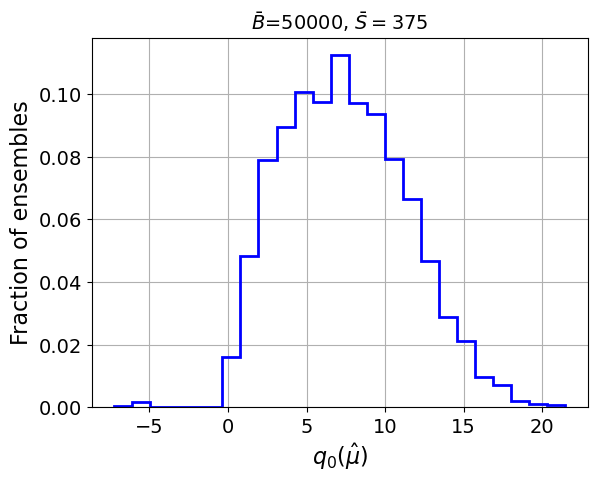

muhat mean:  0.10533364661654136
median q_muhat:  7.238064130883117
Z_gaussian:  2.690365055319281

 ------------------------------------ 

B_expected:  50000
S_expected:  500
S/$\sqrt{B}$:  2.23606797749979
n_ensembles (initial):  5000

 If  10100  =  857    then the proposed range has to be extended
n_ensembles (actual):  4255
This may take long...


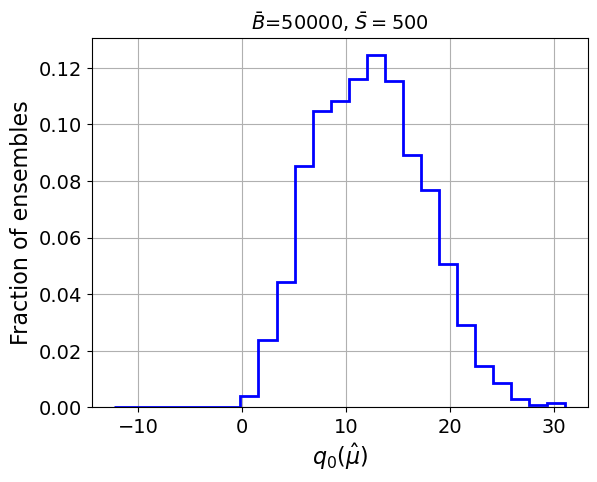

muhat mean:  0.08373678025851941
median q_muhat:  12.141870869393415
Z_gaussian:  3.4845187428672864

 ------------------------------------ 

B_expected:  50000
S_expected:  1250
S/$\sqrt{B}$:  5.5901699437494745
n_ensembles (initial):  5000

 If  10250  =  862    then the proposed range has to be extended
n_ensembles (actual):  4261
This may take long...


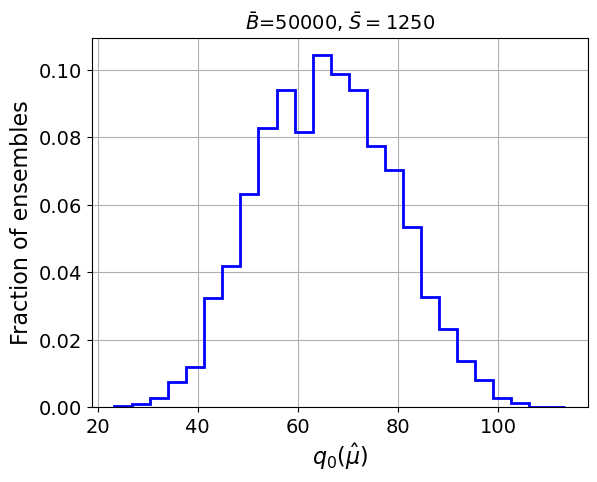

muhat mean:  0.045881248533208165
median q_muhat:  65.79246907527113
Z_gaussian:  8.111255702742401

 ------------------------------------ 

B_expected:  50000
S_expected:  2500
S/$\sqrt{B}$:  11.180339887498949
n_ensembles (initial):  5000

 If  10500  =  869    then the proposed range has to be extended
n_ensembles (actual):  4262
This may take long...


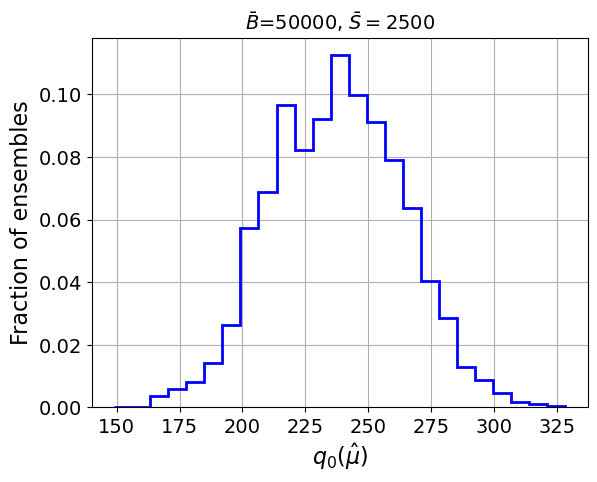

muhat mean:  0.036931018301267014
median q_muhat:  238.01537098886547
Z_gaussian:  15.427746789109078

 ------------------------------------ 

B_expected:  50000
S_expected:  3750
S/$\sqrt{B}$:  16.77050983124842
n_ensembles (initial):  5000

 If  10750  =  878    then the proposed range has to be extended
n_ensembles (actual):  4269
This may take long...


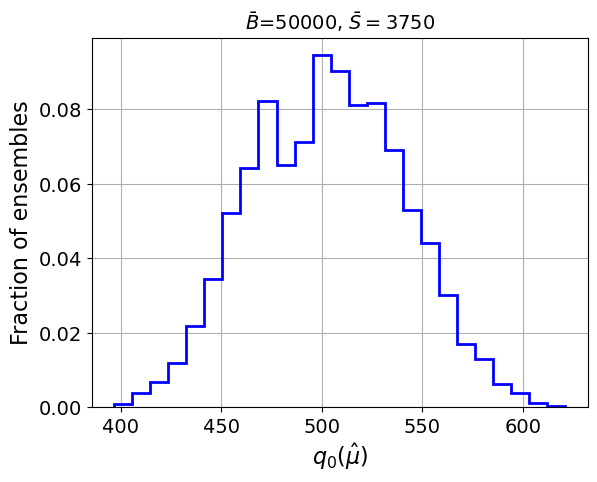

muhat mean:  0.034598266572967905
median q_muhat:  503.29799866905705
Z_gaussian:  22.43430406027914

 ------------------------------------ 



In [22]:
store_muhat_mean_gaussian = []
store_Z_gaussian = []

for iii in range(len(SB_ratio)):

    print('B_expected: ', B_expected)
    print('S_expected: ', S_expected[iii])
    print('S/$\sqrt{B}$: ', SsqrtB[iii])
    print('n_ensembles (initial): ', n_ensembles)
    
    
    # to construct ensembles B and S events are taken from Poisson distributions
    mu = S_expected[iii] + B_expected


    # Letś find the number of events per ensemble such that we get at least one ensemble populated if events are taken from a Poisson distribution

    # around the mean its populated so let's try (proposed range to be checked)
    list_events_per_ensembles = [i for i in range(int(mu*0.9),int(mu*1.1))]
    to_check = len(list_events_per_ensembles)

    # I want at least one ensemble populated
    list_nums_ensembles = [ int( poisson.pmf(list_events_per_ensembles[i],mu)*n_ensembles ) for i in range(len(list_events_per_ensembles)) ]



    # Remove from the list the elements without at least 1 ensemble possible
    for i in range(len(list_events_per_ensembles)):
        if list_nums_ensembles[i] > 1:
            list_events_per_ensembles = list_events_per_ensembles[i:]
            list_nums_ensembles = list_nums_ensembles[i:]
            break


    for i in range(len(list_events_per_ensembles)):
        if list_nums_ensembles[i] < 1:
            list_events_per_ensembles = list_events_per_ensembles[:i]
            list_nums_ensembles = list_nums_ensembles[:i]
            break

    print('\n If ', to_check, ' = ', len(list_events_per_ensembles), '   then the proposed range has to be extended')

    print('n_ensembles (actual): ', sum(list_nums_ensembles))



    # lists of S and B events per ensemble, w.r.t the total of number of events per ensemble found above:

    p_berno = S_expected[iii]/(S_expected[iii]+B_expected)

    list_S_per_ensembles = []
    list_B_per_ensembles = []

    for jj in range(len(list_events_per_ensembles)):
        list_S_per_ensembles.append( int(p_berno * list_events_per_ensembles[jj]) )
        list_B_per_ensembles.append( list_events_per_ensembles[jj] - int(p_berno * list_events_per_ensembles[jj]) )

    ######
    # NOW I HAVE 4 LISTS:
    # list_events_per_ensembles     list with the number of events per ensemble (its a range)
    # list_nums_ensembles           list with the number of ensembles, w.r.t the 1st list
    # list_S_per_ensembles          list with the number of signal events in each ensembles, w.r.t the 1st list
    # list_B_per_ensembles          list with the number of background events in each ensembles, w.r.t the 1st list
    ######
    
    
    
    print('This may take long...')
    
    
    #############################
    # NOW LETS APPLY THE METHOD #
    #############################
    muhat_selected_list = []
    q_muhat = []
    
    for bb in range(len(list_nums_ensembles)):

        for kk in range(list_nums_ensembles[bb]):

#             # SIGNAL events in an ensemble
#             NP_shuf = shuffle(X_gauss_val_NP)[:list_S_per_ensembles[bb]]

#             prob_NP_given_B = [] # p_b(S_ensemble)
#             prob_NP_given_S = [] # p_s(S_ensemble)

#             for ll in range(len(NP_shuf)):
#                 prob_NP_given_S.append( (1./(2*math.pi)**0.5) * math.exp(-0.5*( (NP_shuf[ll,0]-epsilon)**2 + (NP_shuf[ll,1]-epsilon)**2 ) ) )
#                 prob_NP_given_B.append( (1./(2*math.pi)**0.5) * math.exp(-0.5*( (NP_shuf[ll,0]+epsilon)**2 + (NP_shuf[ll,1]+epsilon)**2 ) ) )


            # BACKGROUND events in an ensemble
            SM_shuf = shuffle(X_gauss_val_SM)[:list_B_per_ensembles[bb]]

            prob_SM_given_B = [] # p_b(B_ensemble)
            prob_SM_given_S = [] # p_s(B_ensemble)

            for ll in range(len(SM_shuf)):
                prob_SM_given_S.append( (1./(2*math.pi)**0.5) * math.exp(-0.5*( (SM_shuf[ll,0]-epsilon)**2 + (SM_shuf[ll,1]-epsilon)**2 ) ) )
                prob_SM_given_B.append( (1./(2*math.pi)**0.5) * math.exp(-0.5*( (SM_shuf[ll,0]+epsilon)**2 + (SM_shuf[ll,1]+epsilon)**2 ) ) )


            # p_b(x_ensemble) =    concatenate: p_b(B_ensemble) and p_b(S_ensemble)
            prob_x_given_B = prob_SM_given_B #+ prob_NP_given_B

            # p_s(x_ensemble) =    concatenate: p_s(B_ensemble) and p_s(S_ensemble)
            prob_x_given_S = prob_SM_given_S #+ prob_NP_given_S




            # NOW WE HAVE p_{s,b}(x_ensemble) for this particular ensemble
            # WE NEED TO ESTIMATE mu_hat for this particular ensemble
            # we are going to obtain a mu_hat with a grid of values for this particular ensemble



            mu_hat_condition_equal_1 = []

            # grid, mu_hat should be around 0 for exclusion
            muhat_test = np.arange(0., 1., 0.1).tolist()

            B_prob_x_given_B = [x * B_expected for x in prob_x_given_B]

            for vv in range(len(muhat_test)):

                mu_hat_condition_equal_1.append( sum ( [(x*1.) / ( (x * muhat_test[vv] * S_expected[iii]) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] ) )



            muhat_selected = 0

            # from the grid, select the mu_hat such that the condition is equal to 1
            if mu_hat_condition_equal_1[0] < mu_hat_condition_equal_1[-1]:
                for ll in range(len(mu_hat_condition_equal_1)):
                    if mu_hat_condition_equal_1[ll] -1 > 0:
                        muhat_selected = muhat_test[ll]
                        break


            if mu_hat_condition_equal_1[0] > mu_hat_condition_equal_1[-1]:
                for ll in range(len(mu_hat_condition_equal_1)):
                    if mu_hat_condition_equal_1[ll] -1 < 0:
                        muhat_selected = muhat_test[ll]
                        break


            muhat_selected_list.append(muhat_selected)



            # NOW THAT WE HAVE mu_hat FOR THIS ENSEMBLE, CALCULATE THE TEST STATISTIC FOR THIS ENSEMBLE
            # and append it (we need the median over lots of ensembles)
            # DISCOVERY:
            #q_muhat.append( 2 * ( (-1.*muhat_selected * S_expected[iii]) + sum( [np.log( 1 + ( (muhat_selected*S_expected[iii]/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )
            # EXCLUSION:
            q_muhat.append( 2 * ( ( (1.-muhat_selected) * S_expected[iii] ) - sum( [np.log( ( (B_expected*y) + (S_expected[iii]*x) ) / ( (B_expected*y) + (muhat_selected*S_expected[iii]*x) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] )
 ) )

    # Histogram of q_muhats

    weights = np.ones_like(q_muhat)/float(len(q_muhat))
    nMIX, binsMIX, patchesMIX = plt.hist(q_muhat, 25, weights=weights, histtype='step', color='blue', linewidth=2)
    #plt.xlim(0,1)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel("$q_0(\hat{\mu})$",fontsize=16)
    plt.ylabel("Fraction of ensembles",fontsize=16)
    plt.title(r"$\bar{B}$=%0.2i, $\bar{S}=$%0.2i" % (B_expected,S_expected[iii]),fontsize=14)
    plt.grid()
    #plt.legend(fontsize=14)
    plt.show()


    # Finally calculate muhat_mean and Z_gaussian
    muhat_mean = np.mean(muhat_selected_list)
    store_muhat_mean_gaussian.append(muhat_mean)

    # Remove nan if any
    q_muhat = [x for x in q_muhat if x == x]
    
    q_muhat_median = np.median(q_muhat)

    Z_gaussian = abs(q_muhat_median)**0.5
    store_Z_gaussian.append(Z_gaussian)

    print('muhat mean: ', muhat_mean)
    print('median q_muhat: ', q_muhat_median)
    print('Z_gaussian: ', Z_gaussian)


    print('\n ------------------------------------ \n')



In [23]:
print(store_muhat_mean_gaussian)
print(store_Z_gaussian)

[0.0500822561692127, 0.10855263157894737, 0.12226140103432068, 0.10533364661654136, 0.08373678025851941, 0.045881248533208165, 0.036931018301267014, 0.034598266572967905]
[0.55307458976971, 1.0852407103648487, 1.951804802039797, 2.690365055319281, 3.4845187428672864, 8.111255702742401, 15.427746789109078, 22.43430406027914]


In [77]:
# To use if you dont want to run everything again. Its the previous results
store_muhat_mean_gaussian = [0.0500822561692127, 0.10855263157894737, 0.12226140103432068, 0.10533364661654136, 0.08373678025851941, 0.045881248533208165, 0.036931018301267014, 0.034598266572967905]
store_Z_gaussian = [0.55307458976971, 1.0852407103648487, 1.951804802039797, 2.690365055319281, 3.4845187428672864, 8.111255702742401, 15.427746789109078, 22.43430406027914]

<ipython-input-78-6b2e53b9f67b>:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-ok" (-> color='k'). The keyword argument will take precedence.
  plt.plot(posX, store_muhat_mean_gaussian, '-ok', color='green', lw=lw, label='mu_hat')


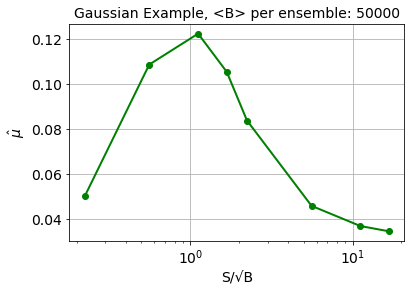

<ipython-input-78-6b2e53b9f67b>:37: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-ok" (-> color='k'). The keyword argument will take precedence.
  plt.plot(posX, store_Z_gaussian, '-ok', color='green', lw=lw, label=r'True pdf Likelihood')
<ipython-input-78-6b2e53b9f67b>:38: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-ok" (-> color='k'). The keyword argument will take precedence.
  plt.plot(posX, store_Z_bins, '-ok', color='dodgerblue', lw=lw, label=r'$\bar{x}$ BL (10 l.bins)')
<ipython-input-78-6b2e53b9f67b>:39: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-ok" (-> color='k'). The keyword argument will take precedence.
  plt.plot(posX, store_Z_bins_class, '-ok', color='blue', lw=lw, label=r'$o(\bar{x})$ BL (10 l.bins)')


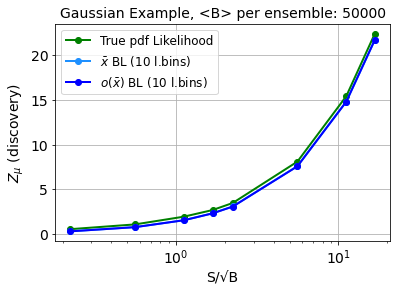

In [78]:
#########
# PLOTS #
#########

posX = []

for i in range(len(SB_ratio)):
    posX.append( (B_expected*SB_ratio[i]) / ( B_expected )**0.5 )




plt.figure()
lw = 2

plt.plot(posX, store_muhat_mean_gaussian, '-ok', color='green', lw=lw, label='mu_hat')

#plt.xlim([0.5, 100])
#plt.ylim([-0.5, 7.5])
plt.xscale('log')
plt.xlabel('S/√B', fontsize=14)
plt.ylabel(r'$\hat{\mu}$', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.title('Gaussian Example, <B> per ensemble: %0.2d' % B_expected, fontsize=14)
plt.show()






plt.figure()
lw = 2

plt.plot(posX, store_Z_gaussian, '-ok', color='green', lw=lw, label=r'True pdf Likelihood')
plt.plot(posX, store_Z_bins, '-ok', color='dodgerblue', lw=lw, label=r'$\bar{x}$ BL (10 l.bins)') 
plt.plot(posX, store_Z_bins_class, '-ok', color='blue', lw=lw, label=r'$o(\bar{x})$ BL (10 l.bins)') 

#plt.xlim([0.5, 10])
#plt.ylim([-0.5, 7.5])
plt.xscale('log')
plt.xlabel('S/√B', fontsize=14)
plt.ylabel('$Z_{\mu}$ (discovery)', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.title('Gaussian Example, <B> per ensemble: %0.2d' % B_expected, fontsize=14)
plt.legend(loc="upper left", fontsize=12)
plt.show()

### 3. MACHINE-LEARNED LIKELIHOOD with Kernel Density Estimator

### KDE 

##### For 1 ML

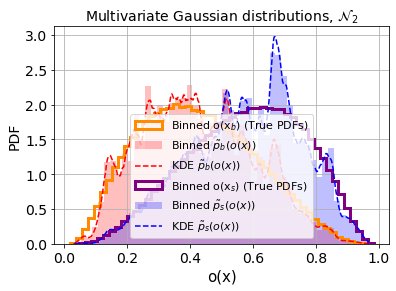

In [99]:
# USE KDE TO ESTIMATE THE CLASSIFIER OUTPUT PDFs



# # FIND THE BANDWIDTH

SM_bandwidth_1ML = 0.01924024182760239
NP_bandwidth_1ML = 0.01924024182760239

# bandwidth = np.logspace(-3.0, 0.05, 20)

# kde = KernelDensity(kernel='epanechnikov')
# grid = GridSearchCV(kde, {'bandwidth': bandwidth})
# grid.fit(np.c_[pred_XG_SM_1ML[:50000]])
# print('Background: ', grid.best_estimator_)

# SM_bandwidth_1ML = grid.best_estimator_.bandwidth



# kde = KernelDensity(kernel='epanechnikov')
# grid = GridSearchCV(kde, {'bandwidth': bandwidth})
# grid.fit(np.c_[pred_XG_NP_1ML[:50000]])
# print('Signal: ', grid.best_estimator_)

# NP_bandwidth_1ML = grid.best_estimator_.bandwidth



# with each calculated bandwidth estimate the pdf with KDE to the classifier output (for background and signal)
# notice: epanechnikov kernel
kde_bkg_1ML = KernelDensity(kernel="epanechnikov", bandwidth=SM_bandwidth_1ML).fit(np.c_[pred_XG_SM_1ML, np.zeros(len(pred_XG_SM_1ML)) ])
kde_sig_1ML = KernelDensity(kernel="epanechnikov", bandwidth=NP_bandwidth_1ML).fit(np.c_[pred_XG_NP_1ML, np.ones(len(pred_XG_NP_1ML)) ])



# range (~between 0 and 1)
min_val_1ML = np.min([np.min(pred_XG_SM_1ML),np.min(pred_XG_NP_1ML)])
max_val_1ML = np.max([np.max(pred_XG_SM_1ML),np.max(pred_XG_NP_1ML)])

s_vals_1ML = np.linspace(min_val_1ML,max_val_1ML,1000)



# evaluate the densities for each value of s (~bins)
dens_bkg_1ML = np.exp(kde_bkg_1ML.score_samples(np.c_[s_vals_1ML, np.zeros(len(s_vals_1ML)) ]) )
dens_sig_1ML = np.exp(kde_sig_1ML.score_samples(np.c_[s_vals_1ML, np.ones(len(s_vals_1ML)) ]) )



# Normalize to 1
# Area
factor_aux_SM_1ML = sum(dens_bkg_1ML*(s_vals_1ML[1]-s_vals_1ML[0]))
factor_aux_NP_1ML = sum(dens_sig_1ML*(s_vals_1ML[1]-s_vals_1ML[0]))

# normalize
dens_bkg_1ML = dens_bkg_1ML / factor_aux_SM_1ML
dens_sig_1ML = dens_sig_1ML / factor_aux_NP_1ML





# plot to check the estimation

plt.figure()

plt.hist(ratio_ps_pb_true_B,density=True,bins=50,lw=3,histtype='step',color='darkorange',alpha=1,label=r'Binned o(x$_b$) (True PDFs)')
plt.hist(pred_XG_SM_1ML,density=True,bins=50,color='red',alpha=0.25,label=r'Binned $\tilde{p}_{b}(o(x))$');
plt.plot(s_vals_1ML,dens_bkg_1ML,color='red',label=r'KDE $\tilde{p}_{b}(o(x))$',linestyle='dashed');

plt.hist(ratio_ps_pb_true_S,density=True,bins=50,lw=3,histtype='step',color='purple',alpha=1,label=r'Binned o(x$_s$) (True PDFs)');
plt.hist(pred_XG_NP_1ML,density=True,bins=50,color='blue',alpha=0.25,label=r'Binned $\tilde{p}_{s}(o(x))$');
plt.plot(s_vals_1ML,dens_sig_1ML,color='blue',label=r'KDE $\tilde{p}_{s}(o(x))$',linestyle='dashed');

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("o(x)",fontsize=15)
plt.ylabel("PDF",fontsize=14)
plt.grid()
plt.legend(loc="lower center", fontsize=11, handlelength=2.5)
plt.title(r'Multivariate Gaussian distributions, $\mathcal{N}_{2}$', fontsize=14)
#plt.savefig('images/' + '2gaussian-output-1ML.pdf', format="pdf", bbox_inches="tight")
plt.show()

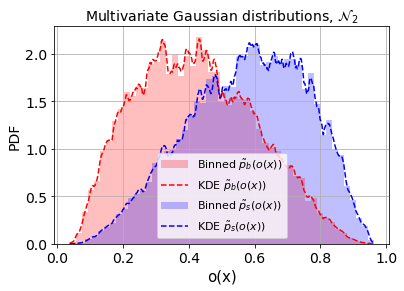

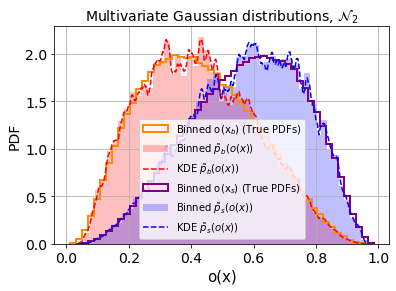

In [49]:
# plot to check the estimation

plt.figure()

plt.hist(pred_XG_SM_1ML,density=True,bins=50,color='red',alpha=0.25,label=r'Binned $\tilde{p}_{b}(o(x))$');
plt.plot(s_vals,dens_bkg_1ML,color='red',label=r'KDE $\tilde{p}_{b}(o(x))$',linestyle='dashed');

plt.hist(pred_XG_NP_1ML,density=True,bins=50,color='blue',alpha=0.25,label=r'Binned $\tilde{p}_{s}(o(x))$');
plt.plot(s_vals,dens_sig_1ML,color='blue',label=r'KDE $\tilde{p}_{s}(o(x))$',linestyle='dashed');

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("o(x)",fontsize=15)
plt.ylabel("PDF",fontsize=14)
plt.grid()
plt.legend(loc="lower center", fontsize=11, handlelength=2.5)
plt.title(r'Multivariate Gaussian distributions, $\mathcal{N}_{2}$', fontsize=14)
#plt.savefig('images/' + '2gaussian-output.pdf', format="pdf", bbox_inches="tight")
plt.show()





plt.figure()

plt.hist(ratio_ps_pb_true_B,density=True,bins=50,lw=2,histtype='step',color='darkorange',alpha=1,label=r'Binned o(x$_b$) (True PDFs)')
plt.hist(pred_XG_SM_1ML,density=True,bins=50,color='red',alpha=0.25,label=r'Binned $\tilde{p}_{b}(o(x))$');
plt.plot(s_vals,dens_bkg_1ML,color='red',label=r'KDE $\tilde{p}_{b}(o(x))$',linestyle='dashed');

plt.hist(ratio_ps_pb_true_S,density=True,bins=50,lw=2,histtype='step',color='purple',alpha=1,label=r'Binned o(x$_s$) (True PDFs)');
plt.hist(pred_XG_NP_1ML,density=True,bins=50,color='blue',alpha=0.25,label=r'Binned $\tilde{p}_{s}(o(x))$');
plt.plot(s_vals,dens_sig_1ML,color='blue',label=r'KDE $\tilde{p}_{s}(o(x))$',linestyle='dashed');

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("o(x)",fontsize=15)
plt.ylabel("PDF",fontsize=14)
plt.grid()
plt.legend(loc="lower center", fontsize=10, handlelength=2.5)
plt.title(r'Multivariate Gaussian distributions, $\mathcal{N}_{2}$', fontsize=14)
plt.savefig('images/' + '2gaussian-output-1ML.pdf', format="pdf", bbox_inches="tight")
plt.show()

##### For 10 ML

/home/andres/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf  3551.78714319
  3553.2587464   3551.82093424  3546.75365481  3533.03967195
  3499.83950916  3426.35113028  3274.28347928  2950.48638859
  2263.34502884   892.46996861 -1447.83041352 -4538.95126197]
  warnings.warn(
/home/andres/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:961: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Background:  KernelDensity(bandwidth=0.01924024182760239, kernel='epanechnikov')


/home/andres/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
  3531.28928225  3529.22069771  3522.36279485  3504.92023829
  3467.72862099  3390.68812983  3230.92909679  2896.88086427
  2209.8043104    860.85274136 -1461.4769433  -4545.22666626]
  warnings.warn(
/home/andres/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:961: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


Signal:  KernelDensity(bandwidth=0.01924024182760239, kernel='epanechnikov')


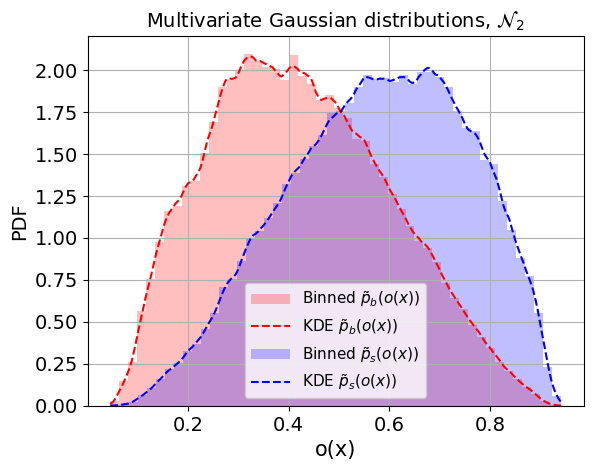

In [25]:
# USE KDE TO ESTIMATE THE CLASSIFIER OUTPUT PDFs



# # FIND THE BANDWIDTH

#SM_bandwidth = 0.0127
#NP_bandwidth = 0.0127

bandwidth = np.logspace(-3.0, 0.05, 20)

kde = KernelDensity(kernel='epanechnikov')
grid = GridSearchCV(kde, {'bandwidth': bandwidth})
grid.fit(np.c_[pred_XG_SM[:50000]])
print('Background: ', grid.best_estimator_)

SM_bandwidth = grid.best_estimator_.bandwidth



kde = KernelDensity(kernel='epanechnikov')
grid = GridSearchCV(kde, {'bandwidth': bandwidth})
grid.fit(np.c_[pred_XG_NP[:50000]])
print('Signal: ', grid.best_estimator_)

NP_bandwidth = grid.best_estimator_.bandwidth



# with each calculated bandwidth estimate the pdf with KDE to the classifier output (for background and signal)
# notice: epanechnikov kernel
kde_bkg = KernelDensity(kernel="epanechnikov", bandwidth=SM_bandwidth).fit(np.c_[pred_XG_SM, np.zeros(len(pred_XG_SM)) ])
kde_sig = KernelDensity(kernel="epanechnikov", bandwidth=NP_bandwidth).fit(np.c_[pred_XG_NP, np.ones(len(pred_XG_NP)) ])



# range (~between 0 and 1)
min_val = np.min([np.min(pred_XG_SM),np.min(pred_XG_NP)])
max_val = np.max([np.max(pred_XG_SM),np.max(pred_XG_NP)])

s_vals = np.linspace(min_val,max_val,1000)



# evaluate the densities for each value of s (~bins)
dens_bkg = np.exp(kde_bkg.score_samples(np.c_[s_vals, np.zeros(len(s_vals)) ]) )
dens_sig = np.exp(kde_sig.score_samples(np.c_[s_vals, np.ones(len(s_vals)) ]) )



# Normalize to 1
# Area
factor_aux_SM = sum(dens_bkg*(s_vals[1]-s_vals[0]))
factor_aux_NP = sum(dens_sig*(s_vals[1]-s_vals[0]))

# normalize
dens_bkg = dens_bkg / factor_aux_SM
dens_sig = dens_sig / factor_aux_NP





# plot to check the estimation

plt.figure()

plt.hist(ratio_ps_pb_true_B,density=True,bins=50,lw=3,histtype='step',color='darkorange',alpha=1,label=r'Binned o(x$_b$) (True PDFs)')
plt.hist(pred_XG_SM,density=True,bins=50,color='red',alpha=0.25,label=r'Binned $\tilde{p}_{b}(o(x))$');
plt.plot(s_vals,dens_bkg,color='red',label=r'KDE $\tilde{p}_{b}(o(x))$',linestyle='dashed');

plt.hist(ratio_ps_pb_true_S,density=True,bins=50,lw=3,histtype='step',color='purple',alpha=1,label=r'Binned o(x$_s$) (True PDFs)');
plt.hist(pred_XG_NP,density=True,bins=50,color='blue',alpha=0.25,label=r'Binned $\tilde{p}_{s}(o(x))$');
plt.plot(s_vals,dens_sig,color='blue',label=r'KDE $\tilde{p}_{s}(o(x))$',linestyle='dashed');

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("o(x)",fontsize=15)
plt.ylabel("PDF",fontsize=14)
plt.grid()
plt.legend(loc="lower center", fontsize=11, handlelength=2.5)
plt.title(r'Multivariate Gaussian distributions, $\mathcal{N}_{2}$', fontsize=14)
#plt.savefig('images/' + '2gaussian-output-10ML.pdf', format="pdf", bbox_inches="tight")
plt.show()

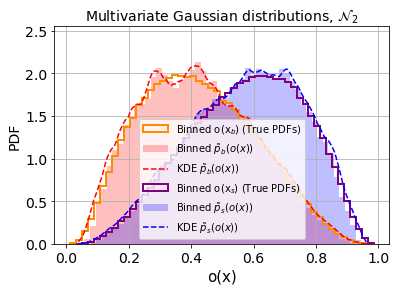

In [52]:
plt.figure()

plt.hist(ratio_ps_pb_true_B,density=True,bins=50,lw=2,histtype='step',color='darkorange',alpha=1,label=r'Binned o(x$_b$) (True PDFs)')
plt.hist(pred_XG_SM,density=True,bins=50,color='red',alpha=0.25,label=r'Binned $\tilde{p}_{b}(o(x))$');
plt.plot(s_vals,dens_bkg,color='red',label=r'KDE $\tilde{p}_{b}(o(x))$',linestyle='dashed');

plt.hist(ratio_ps_pb_true_S,density=True,bins=50,lw=2,histtype='step',color='purple',alpha=1,label=r'Binned o(x$_s$) (True PDFs)');
plt.hist(pred_XG_NP,density=True,bins=50,color='blue',alpha=0.25,label=r'Binned $\tilde{p}_{s}(o(x))$');
plt.plot(s_vals,dens_sig,color='blue',label=r'KDE $\tilde{p}_{s}(o(x))$',linestyle='dashed');

plt.ylim([0,2.55])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("o(x)",fontsize=15)
plt.ylabel("PDF",fontsize=14)
plt.grid()
plt.legend(loc="lower center", fontsize=10, handlelength=2.5)
plt.title(r'Multivariate Gaussian distributions, $\mathcal{N}_{2}$', fontsize=14)
plt.savefig('images/' + '2gaussian-output-10ML.pdf', format="pdf", bbox_inches="tight")
plt.show()

B_expected:  50000


/tmp/ipykernel_76926/1127531003.py:59: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-ok" (-> color='k'). The keyword argument will take precedence.
  plt.plot(posX, store_Z_gaussian, '-ok', color='green', lw=lw, label=r'True pdf Likelihood')
/tmp/ipykernel_76926/1127531003.py:60: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-ok" (-> color='k'). The keyword argument will take precedence.
  plt.plot(posX, store_Z_bins, '-ok', color='dodgerblue', lw=lw, label=r'$\bar{x}$ Binned Likelihood')
/tmp/ipykernel_76926/1127531003.py:61: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-ok" (-> color='k'). The keyword argument will take precedence.
  plt.plot(posX, store_Z_bins_class, '-ok', color='blue', lw=lw, label=r'$o(\bar{x})$ Binned Likelihood')


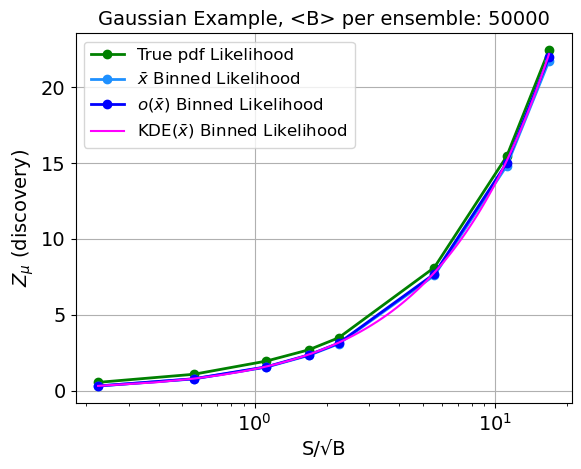

In [26]:
# We can do a quick Z bin-loglikelihood calculation using the computed KDE
# this is to check the KDE here, because we use KDE to avoid binning


# in each ensemble we use B=50k
print('B_expected: ', B_expected)

# values of S / sqrt{B} to test 
soversqrtB = np.linspace(SsqrtB[0],SsqrtB[-1],100)



# Let's find out the expected number of B and S events in each bin:

# total number of B * B_pdf value in each bin * bin size
Bd = B_expected*dens_bkg*(s_vals[1]-s_vals[0])



# If a bins has no expected background events replace that zero for the minimum B_bin=/=0

# find the minimum
Bd_noceros = []
for i in range(len(Bd)):
    if Bd[i]!=0:
        Bd_noceros.append(Bd[i])

min_back = min(Bd_noceros)

# replace the zeros
for i in range(len(Bd)):
    if Bd[i]==0:
        Bd[i] = min_back




# Now calculate Z using the Binned Likelihood formula

Zvals = np.zeros(len(soversqrtB))

for nval, val in enumerate(soversqrtB):
    # S events in each bin: 
    # value of S/sqrt{B} * sqrt{B} * S_pdf value in each bin * bin size
    Sd = val*np.sqrt(B_expected)*dens_sig*(s_vals[1]-s_vals[0])
    
    # Z value:
    #Zvals[nval]= np.sqrt(2.0*np.sum(((Sd+Bd)*np.log(1.0+Sd/Bd)-Sd))) # Discovery
    Zvals[nval]= np.sqrt(2.0*np.sum(Bd*np.log(Bd/(Sd+Bd))+Sd)) # Exclusion

    
    
    
# PLOT

plt.figure()
lw = 2

plt.plot(posX, store_Z_gaussian, '-ok', color='green', lw=lw, label=r'True pdf Likelihood')
plt.plot(posX, store_Z_bins, '-ok', color='dodgerblue', lw=lw, label=r'$\bar{x}$ BL (10 l.bins)') 
plt.plot(posX, store_Z_bins_class, '-ok', color='blue', lw=lw, label=r'$o(\bar{x})$ BL (10 l.bins)') 
plt.plot(soversqrtB, Zvals, color='magenta', label=r'KDE$(\bar{x})$ BL (10 l.bins)') 

#plt.xlim([0.5, 10])
#plt.ylim([-0.5, 7.5])
plt.xscale('log')
plt.xlabel('S/√B', fontsize=14)
plt.ylabel('$Z_{\mu}$ (discovery)', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.title('Gaussian Example, <B> per ensemble: %0.2d' % B_expected, fontsize=14)
plt.legend(loc="upper left", fontsize=12)
plt.show()

### MLL + KDE

In [27]:
# FOR EXCLUSION:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND EVENTS

# FOR DISCOVERY:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND and SIGNAL EVENTS

##### For 1 ML

In [100]:
KDE_SM_pred_SM_1ML = np.exp(kde_bkg_1ML.score_samples(np.c_[pred_XG_SM_1ML, np.zeros(len(pred_XG_SM_1ML)) ]) )

KDE_NP_pred_SM_1ML = np.exp(kde_sig_1ML.score_samples(np.c_[pred_XG_SM_1ML, np.ones(len(pred_XG_SM_1ML)) ]) )

In [101]:
# Normalize

KDE_SM_pred_SM_1ML = KDE_SM_pred_SM_1ML / factor_aux_SM_1ML
KDE_NP_pred_SM_1ML = KDE_NP_pred_SM_1ML / factor_aux_NP_1ML

B_expected:  50000
S_expected:  50
S/$\sqrt{B}$:  0.22360679774997896
n_ensembles (initial):  5000

 If  10010  =  855    then the proposed range has to be extended
n_ensembles (actual):  4255

 This may take long... 



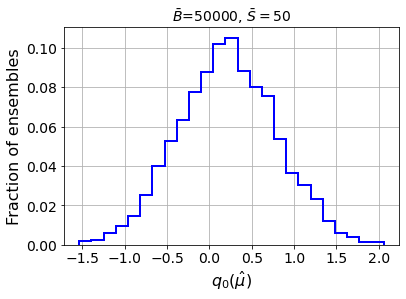

muhat mean:  0.05984488836662749
median q_muhat:  0.2176297456637002
Z_KDE:  0.4665080338683356
Z_KDE_mu0:  0.4665080338683356

 -------------------------------- 

B_expected:  50000
S_expected:  125
S/$\sqrt{B}$:  0.5590169943749475
n_ensembles (initial):  5000

 If  10025  =  856    then the proposed range has to be extended
n_ensembles (actual):  4256

 This may take long... 



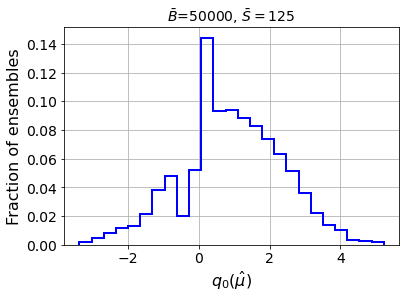

muhat mean:  0.12258223684210527
median q_muhat:  0.9115684148936936
Z_KDE:  0.9547609202798854
Z_KDE_mu0:  0.9547609202798854

 -------------------------------- 

B_expected:  50000
S_expected:  250
S/$\sqrt{B}$:  1.118033988749895
n_ensembles (initial):  5000

 If  10050  =  856    then the proposed range has to be extended
n_ensembles (actual):  4254

 This may take long... 



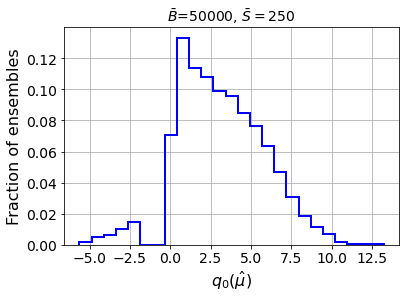

muhat mean:  0.1576586741889986
median q_muhat:  2.950051274761279
Z_KDE:  1.7175713303270053
Z_KDE_mu0:  1.7175713303270053

 -------------------------------- 

B_expected:  50000
S_expected:  375
S/$\sqrt{B}$:  1.6770509831248424
n_ensembles (initial):  5000

 If  10075  =  857    then the proposed range has to be extended
n_ensembles (actual):  4256

 This may take long... 



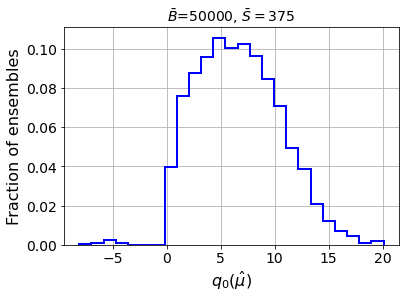

muhat mean:  0.1340437030075188
median q_muhat:  6.480660408405015
Z_KDE:  2.545714125428269
Z_KDE_mu0:  2.545714125428269

 -------------------------------- 

B_expected:  50000
S_expected:  500
S/$\sqrt{B}$:  2.23606797749979
n_ensembles (initial):  5000

 If  10100  =  857    then the proposed range has to be extended
n_ensembles (actual):  4255

 This may take long... 



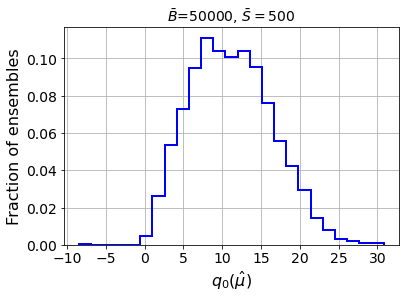

muhat mean:  0.11065099882491188
median q_muhat:  10.861419196983547
Z_KDE:  3.2956667302662064
Z_KDE_mu0:  3.2956667302662064

 -------------------------------- 

B_expected:  50000
S_expected:  1250
S/$\sqrt{B}$:  5.5901699437494745
n_ensembles (initial):  5000

 If  10250  =  862    then the proposed range has to be extended
n_ensembles (actual):  4261

 This may take long... 



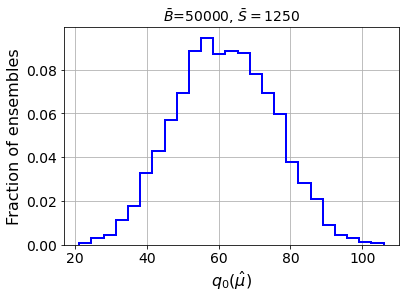

muhat mean:  0.06113588359540014
median q_muhat:  61.38300210504349
Z_KDE:  7.834730506216758
Z_KDE_mu0:  7.834730506216758

 -------------------------------- 

B_expected:  50000
S_expected:  2500
S/$\sqrt{B}$:  11.180339887498949
n_ensembles (initial):  5000

 If  10500  =  869    then the proposed range has to be extended
n_ensembles (actual):  4262

 This may take long... 



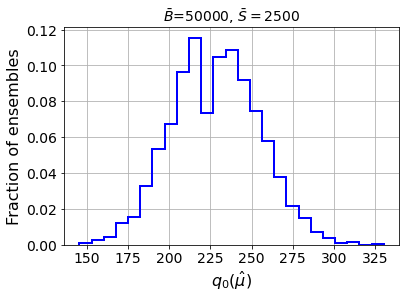

muhat mean:  0.045870483341154386
median q_muhat:  228.46667969537066
Z_KDE:  15.115114279930888
Z_KDE_mu0:  15.115114279930888

 -------------------------------- 

B_expected:  50000
S_expected:  3750
S/$\sqrt{B}$:  16.77050983124842
n_ensembles (initial):  5000

 If  10750  =  878    then the proposed range has to be extended
n_ensembles (actual):  4269

 This may take long... 



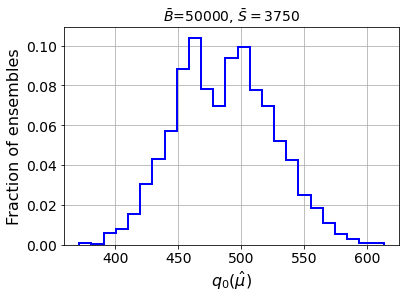

muhat mean:  0.04321855235418131
median q_muhat:  487.353473647343
Z_KDE:  22.076083747969044
Z_KDE_mu0:  22.076083747969044

 -------------------------------- 



In [105]:
store_muhat_mean_MLL_KDE_1ML = []
store_Z_MLL_KDE_1ML = []
store_Z_MLL_KDE_mu0_1ML = []


indices = [i for i in range(len(KDE_NP_pred_SM_1ML))]


for iii in range(len(SB_ratio)):
    
    print('B_expected: ', B_expected)
    print('S_expected: ', S_expected[iii])
    print(r'S/$\sqrt{B}$: ', SsqrtB[iii])
    print('n_ensembles (initial): ', n_ensembles)


    # to construct ensembles B and S events are taken from Poisson distributions
    mu = S_expected[iii] + B_expected


    # Letś find the number of events per ensemble such that we get at least one ensemble populated if events are taken from a Poisson distribution

    # around the mean its populated so let's try (proposed range to be checked)
    list_events_per_ensembles = [i for i in range(int(mu*0.9),int(mu*1.1))]
    to_check = len(list_events_per_ensembles)

    # I want at least one ensemble populated
    list_nums_ensembles = [ int( poisson.pmf(list_events_per_ensembles[i],mu)*n_ensembles ) for i in range(len(list_events_per_ensembles)) ]



    # Remove from the list the elements without at least 1 ensemble possible
    for i in range(len(list_events_per_ensembles)):
        if list_nums_ensembles[i] > 1:
            list_events_per_ensembles = list_events_per_ensembles[i:]
            list_nums_ensembles = list_nums_ensembles[i:]
            break


    for i in range(len(list_events_per_ensembles)):
        if list_nums_ensembles[i] < 1:
            list_events_per_ensembles = list_events_per_ensembles[:i]
            list_nums_ensembles = list_nums_ensembles[:i]
            break

    print('\n If ', to_check, ' = ', len(list_events_per_ensembles), '   then the proposed range has to be extended')

    print('n_ensembles (actual): ', sum(list_nums_ensembles))



    # lists of S and B events per ensemble, w.r.t the total of number of events per ensemble found above:

    p_berno = S_expected[iii]/(S_expected[iii]+B_expected)

    list_S_per_ensembles = []
    list_B_per_ensembles = []

    for jj in range(len(list_events_per_ensembles)):
        list_S_per_ensembles.append( int(p_berno * list_events_per_ensembles[jj]) )
        list_B_per_ensembles.append( list_events_per_ensembles[jj] - int(p_berno * list_events_per_ensembles[jj]) )

    ######
    # NOW I HAVE 4 LISTS:
    # list_events_per_ensembles     list with the number of events per ensemble (its a range)
    # list_nums_ensembles           list with the number of ensembles, w.r.t the 1st list
    # list_S_per_ensembles          list with the number of signal events in each ensembles, w.r.t the 1st list
    # list_B_per_ensembles          list with the number of background events in each ensembles, w.r.t the 1st list
    ######



    print('\n This may take long... \n')
    
    
    #############################
    # NOW LETS APPLY THE METHOD #
    #############################

    muhat_selected_list = []
    q_muhat = []
    q_muhat_mu0 = []
    
    for bb in range(len(list_nums_ensembles)):

        for kk in range(list_nums_ensembles[bb]):
            
            # KDE
            ran_ind = np.random.choice(indices, list_B_per_ensembles[bb])

            KDE_SM_pred_SM_shuf = []
            KDE_NP_pred_SM_shuf = []

            for i in ran_ind:
                KDE_SM_pred_SM_shuf.append(KDE_SM_pred_SM_1ML[i])
                KDE_NP_pred_SM_shuf.append(KDE_NP_pred_SM_1ML[i])

            KDE_SM_pred_SM_shuf  = np.array(KDE_SM_pred_SM_shuf)
            KDE_NP_pred_SM_shuf  = np.array(KDE_NP_pred_SM_shuf)





            # p_b(o(x_ensemble)) =    concatenate: p_b(o(B_ensemble)) and p_b(o(S_ensemble))  NOTICE THE o(x)
            prob_x_given_B = np.ndarray.tolist( KDE_SM_pred_SM_shuf ) #+ np.ndarray.tolist( KDE_SM_pred_NP_shuf )

            # p_s(o(x_ensemble)) =    concatenate: p_s(o(B_ensemble)) and p_s(o(S_ensemble))  NOTICE THE o(x)
            prob_x_given_S = np.ndarray.tolist( KDE_NP_pred_SM_shuf ) #+ np.ndarray.tolist( KDE_NP_pred_NP_shuf )



            
            
            # NOW WE HAVE p_{s,b}(x_ensemble) for this particular ensemble
            # WE NEED TO ESTIMATE mu_hat for this particular ensemble
            # we are going to obtain a mu_hat with a grid of values for this particular ensemble



            mu_hat_condition_equal_1 = []

            # grid, mu_hat is around 1
            muhat_test = np.arange(0., 1., 0.1).tolist()

            B_prob_x_given_B = [x * B_expected for x in prob_x_given_B]

            for vv in range(len(muhat_test)):

                mu_hat_condition_equal_1.append( sum ( [(x*1.) / ( (x * muhat_test[vv] * S_expected[iii]) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] ) )



            muhat_selected = 0.01

            # from the grid, select the mu_hat such that the condition is equal to 1
            if mu_hat_condition_equal_1[0] < mu_hat_condition_equal_1[-1]:
                for ll in range(len(mu_hat_condition_equal_1)):
                    if mu_hat_condition_equal_1[ll] -1 > 0:
                        muhat_selected = muhat_test[ll]
                        break


            if mu_hat_condition_equal_1[0] > mu_hat_condition_equal_1[-1]:
                for ll in range(len(mu_hat_condition_equal_1)):
                    if mu_hat_condition_equal_1[ll] -1 < 0:
                        muhat_selected = muhat_test[ll]
                        break


            muhat_selected_list.append(muhat_selected)



            # NOW THAT WE HAVE mu_hat FOR THIS ENSEMBLE, CALCULATE THE TEST STATISTIC FOR THIS ENSEMBLE
            # and append it (we need the median over lots of ensembles)
            #q_muhat.append( 2 * ( (-1.*muhat_selected * S_expected[iii]) + sum( [np.log( 1 + ( (muhat_selected*S_expected[iii]/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )
            #q_muhat_mu0.append( 2 * ( (-1.*1. * S_expected[iii]) + sum( [np.log( 1 + ( (1.*S_expected[iii]/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )
            # EXCLUSION:
            q_muhat.append( 2 * ( ( (1.-muhat_selected) * S_expected[iii] ) - sum( [np.log( ( (B_expected*y) + (S_expected[iii]*x) ) / ( (B_expected*y) + (muhat_selected*S_expected[iii]*x) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )
            q_muhat_mu0.append( 2 * ( ( (1.-0.) * S_expected[iii] ) - sum( [np.log( ( (B_expected*y) + (S_expected[iii]*x) ) / ( (B_expected*y) + (0.*S_expected[iii]*x) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )


    # Histogram of q_muhats

    weights = np.ones_like(q_muhat)/float(len(q_muhat))
    nMIX, binsMIX, patchesMIX = plt.hist(q_muhat, 25, weights=weights, histtype='step', color='blue', linewidth=2)
    #plt.xlim(0,1)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel("$q_0(\hat{\mu})$",fontsize=16)
    plt.ylabel("Fraction of ensembles",fontsize=16)
    plt.title(r"$\bar{B}$=%0.2i, $\bar{S}=$%0.2i" % (B_expected,S_expected[iii]),fontsize=14)
    plt.grid()
    #plt.legend(fontsize=14)
    plt.show()


    # Finally calculate muhat_mean and Z_gaussian

    # Remove nan if any
    q_muhat_mu0 = [x for x in q_muhat_mu0 if x == x]
    for jk in range(len(q_muhat_mu0)):
        if q_muhat_mu0[jk] < 0:
            q_muhat_mu0[jk] = 0

    q_muhat_median_mu0 = np.median(q_muhat_mu0)

    Z_KDE_mu0 = abs(q_muhat_median_mu0)**0.5
    store_Z_MLL_KDE_mu0_1ML.append(Z_KDE_mu0)
    
    
    
    # Finally calculate muhat_mean and Z_gaussian
    muhat_mean = np.mean(muhat_selected_list)
    store_muhat_mean_MLL_KDE_1ML.append(muhat_mean)
    
    # Remove nan if any
    q_muhat = [x for x in q_muhat if x == x]
    for jk in range(len(q_muhat)):
        if q_muhat[jk] < 0:
            q_muhat[jk] = 0

    q_muhat_median = np.median(q_muhat)

    Z_KDE = abs(q_muhat_median)**0.5
    store_Z_MLL_KDE_1ML.append(Z_KDE)
    

    print('muhat mean: ', muhat_mean)
    print('median q_muhat: ', q_muhat_median)
    print('Z_KDE: ', Z_KDE)
    print('Z_KDE_mu0: ', Z_KDE_mu0)

    print('\n -------------------------------- \n')

In [106]:
print(store_muhat_mean_MLL_KDE_1ML)
print(store_Z_MLL_KDE_1ML)
print(store_Z_MLL_KDE_mu0_1ML)

[0.05984488836662749, 0.12258223684210527, 0.1576586741889986, 0.1340437030075188, 0.11065099882491188, 0.06113588359540014, 0.045870483341154386, 0.04321855235418131]
[0.4665080338683356, 0.9547609202798854, 1.7175713303270053, 2.545714125428269, 3.2956667302662064, 7.834730506216758, 15.115114279930888, 22.076083747969044]
[0.4665080338683356, 0.9547609202798854, 1.7175713303270053, 2.545714125428269, 3.2956667302662064, 7.834730506216758, 15.115114279930888, 22.076083747969044]


In [107]:
store_muhat_mean_MLL_KDE_1ML = [0.05984488836662749, 0.12258223684210527, 0.1576586741889986, 0.1340437030075188, 0.11065099882491188, 0.06113588359540014, 0.045870483341154386, 0.04321855235418131]
store_Z_MLL_KDE_1ML = [0.4665080338683356, 0.9547609202798854, 1.7175713303270053, 2.545714125428269, 3.2956667302662064, 7.834730506216758, 15.115114279930888, 22.076083747969044]
store_Z_MLL_KDE_mu0_1ML = [0.4665080338683356, 0.9547609202798854, 1.7175713303270053, 2.545714125428269, 3.2956667302662064, 7.834730506216758, 15.115114279930888, 22.076083747969044]

##### For 10 ML

In [28]:
KDE_SM_pred_SM = np.exp(kde_bkg.score_samples(np.c_[pred_XG_SM, np.zeros(len(pred_XG_SM)) ]) )

In [29]:
KDE_NP_pred_SM = np.exp(kde_sig.score_samples(np.c_[pred_XG_SM, np.ones(len(pred_XG_SM)) ]) )

In [30]:
# Normalize

KDE_SM_pred_SM = KDE_SM_pred_SM / factor_aux_SM
KDE_NP_pred_SM = KDE_NP_pred_SM / factor_aux_NP

B_expected:  50000
S_expected:  50
S/$\sqrt{B}$:  0.22360679774997896
n_ensembles (initial):  5000

 If  10010  =  855    then the proposed range has to be extended
n_ensembles (actual):  4255

 This may take long... 



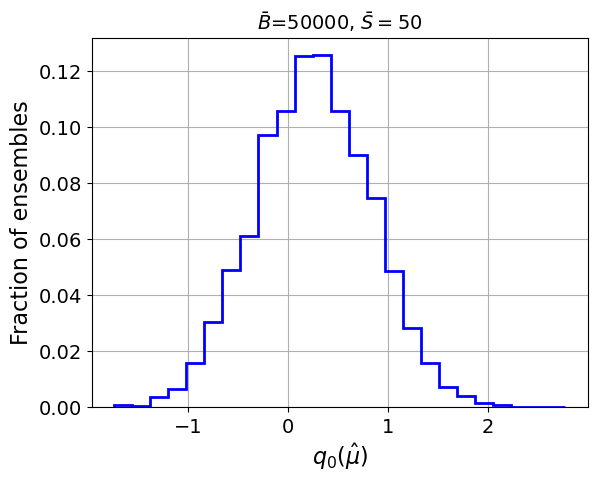

muhat mean:  0.059497062279670984
median q_muhat:  0.25009937488628964
Z_KDE:  0.5000993650128839
Z_KDE_mu0:  0.5000993650128839

 -------------------------------- 

B_expected:  50000
S_expected:  125
S/$\sqrt{B}$:  0.5590169943749475
n_ensembles (initial):  5000

 If  10025  =  856    then the proposed range has to be extended
n_ensembles (actual):  4256

 This may take long... 



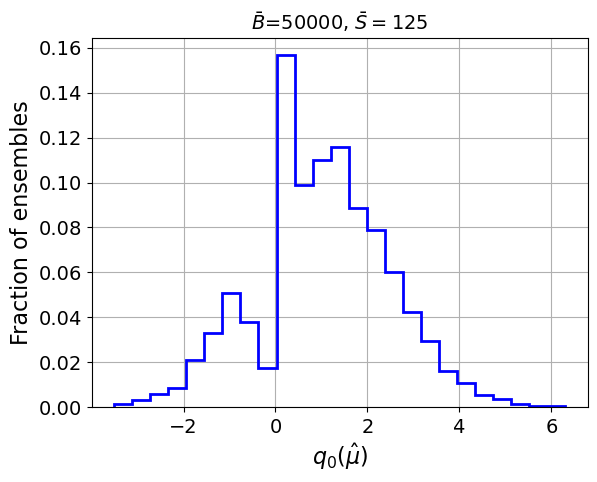

muhat mean:  0.10881343984962406
median q_muhat:  1.0450828809747605
Z_KDE:  1.0222929526191407
Z_KDE_mu0:  1.0222929526191407

 -------------------------------- 

B_expected:  50000
S_expected:  250
S/$\sqrt{B}$:  1.118033988749895
n_ensembles (initial):  5000

 If  10050  =  856    then the proposed range has to be extended
n_ensembles (actual):  4254

 This may take long... 



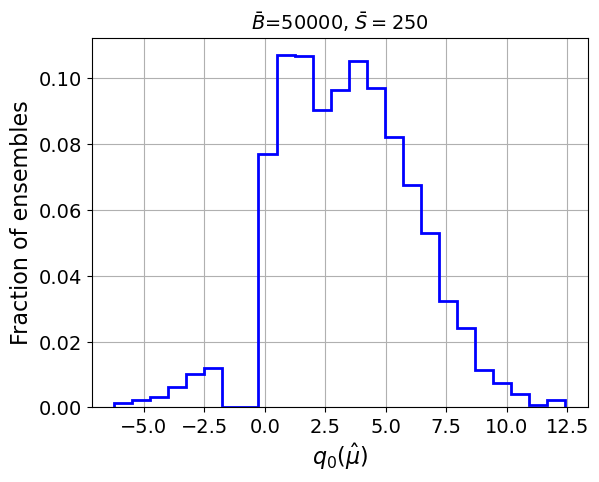

muhat mean:  0.14370004701457453
median q_muhat:  3.3540351123886296
Z_KDE:  1.8314024987393214
Z_KDE_mu0:  1.8314024987393214

 -------------------------------- 

B_expected:  50000
S_expected:  375
S/$\sqrt{B}$:  1.6770509831248424
n_ensembles (initial):  5000

 If  10075  =  857    then the proposed range has to be extended
n_ensembles (actual):  4256

 This may take long... 



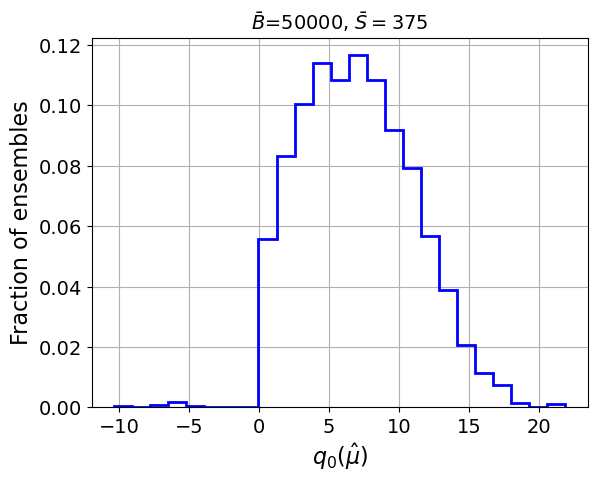

muhat mean:  0.12938674812030077
median q_muhat:  6.805341835007596
Z_KDE:  2.6087050111132912
Z_KDE_mu0:  2.6087050111132912

 -------------------------------- 

B_expected:  50000
S_expected:  500
S/$\sqrt{B}$:  2.23606797749979
n_ensembles (initial):  5000

 If  10100  =  857    then the proposed range has to be extended
n_ensembles (actual):  4255

 This may take long... 



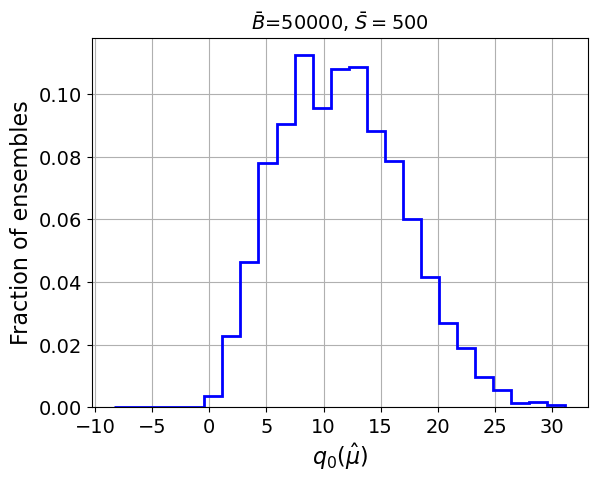

muhat mean:  0.10373913043478263
median q_muhat:  11.33155867171763
Z_KDE:  3.366238059275908
Z_KDE_mu0:  3.366238059275908

 -------------------------------- 

B_expected:  50000
S_expected:  1250
S/$\sqrt{B}$:  5.5901699437494745
n_ensembles (initial):  5000

 If  10250  =  862    then the proposed range has to be extended
n_ensembles (actual):  4261

 This may take long... 



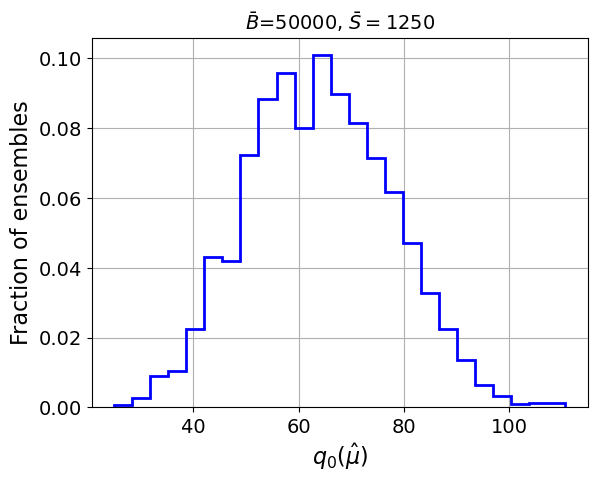

muhat mean:  0.05350856606430415
median q_muhat:  63.6867673676461
Z_KDE:  7.980398947900167
Z_KDE_mu0:  7.980398947900167

 -------------------------------- 

B_expected:  50000
S_expected:  2500
S/$\sqrt{B}$:  11.180339887498949
n_ensembles (initial):  5000

 If  10500  =  869    then the proposed range has to be extended
n_ensembles (actual):  4262

 This may take long... 



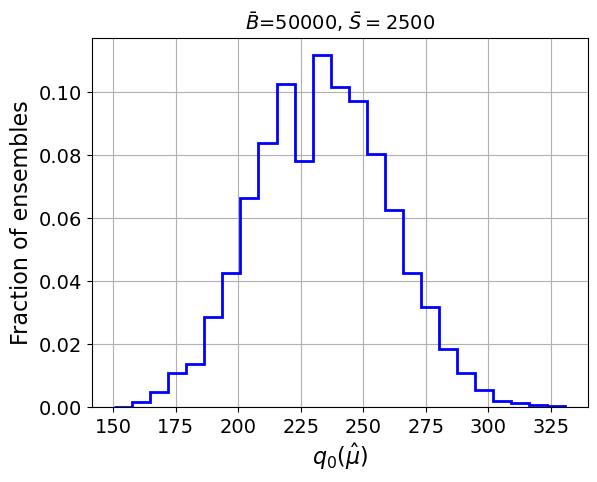

muhat mean:  0.04213984045049272
median q_muhat:  234.0121842313697
Z_KDE:  15.297456789655257
Z_KDE_mu0:  15.297456789655257

 -------------------------------- 

B_expected:  50000
S_expected:  3750
S/$\sqrt{B}$:  16.77050983124842
n_ensembles (initial):  5000

 If  10750  =  878    then the proposed range has to be extended
n_ensembles (actual):  4269

 This may take long... 



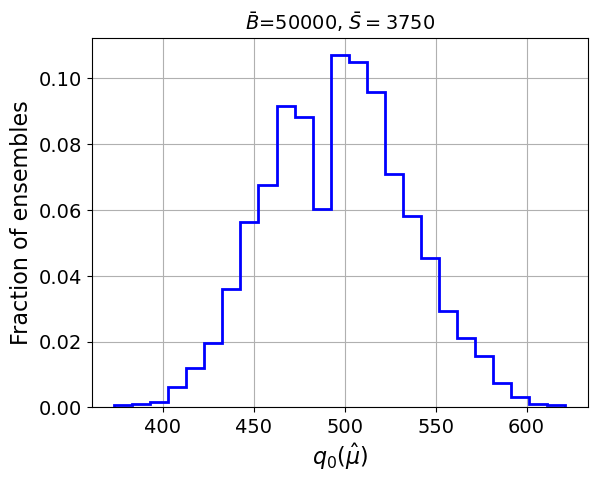

muhat mean:  0.040009369875849146
median q_muhat:  497.8470283428396
Z_KDE:  22.312485929246872
Z_KDE_mu0:  22.312485929246872

 -------------------------------- 



In [31]:
store_muhat_mean_MLL_KDE = []
store_Z_MLL_KDE = []
store_Z_MLL_KDE_mu0 = []


indices = [i for i in range(len(KDE_NP_pred_SM))]


for iii in range(len(SB_ratio)):
    
    print('B_expected: ', B_expected)
    print('S_expected: ', S_expected[iii])
    print(r'S/$\sqrt{B}$: ', SsqrtB[iii])
    print('n_ensembles (initial): ', n_ensembles)


    # to construct ensembles B and S events are taken from Poisson distributions
    mu = S_expected[iii] + B_expected


    # Letś find the number of events per ensemble such that we get at least one ensemble populated if events are taken from a Poisson distribution

    # around the mean its populated so let's try (proposed range to be checked)
    list_events_per_ensembles = [i for i in range(int(mu*0.9),int(mu*1.1))]
    to_check = len(list_events_per_ensembles)

    # I want at least one ensemble populated
    list_nums_ensembles = [ int( poisson.pmf(list_events_per_ensembles[i],mu)*n_ensembles ) for i in range(len(list_events_per_ensembles)) ]



    # Remove from the list the elements without at least 1 ensemble possible
    for i in range(len(list_events_per_ensembles)):
        if list_nums_ensembles[i] > 1:
            list_events_per_ensembles = list_events_per_ensembles[i:]
            list_nums_ensembles = list_nums_ensembles[i:]
            break


    for i in range(len(list_events_per_ensembles)):
        if list_nums_ensembles[i] < 1:
            list_events_per_ensembles = list_events_per_ensembles[:i]
            list_nums_ensembles = list_nums_ensembles[:i]
            break

    print('\n If ', to_check, ' = ', len(list_events_per_ensembles), '   then the proposed range has to be extended')

    print('n_ensembles (actual): ', sum(list_nums_ensembles))



    # lists of S and B events per ensemble, w.r.t the total of number of events per ensemble found above:

    p_berno = S_expected[iii]/(S_expected[iii]+B_expected)

    list_S_per_ensembles = []
    list_B_per_ensembles = []

    for jj in range(len(list_events_per_ensembles)):
        list_S_per_ensembles.append( int(p_berno * list_events_per_ensembles[jj]) )
        list_B_per_ensembles.append( list_events_per_ensembles[jj] - int(p_berno * list_events_per_ensembles[jj]) )

    ######
    # NOW I HAVE 4 LISTS:
    # list_events_per_ensembles     list with the number of events per ensemble (its a range)
    # list_nums_ensembles           list with the number of ensembles, w.r.t the 1st list
    # list_S_per_ensembles          list with the number of signal events in each ensembles, w.r.t the 1st list
    # list_B_per_ensembles          list with the number of background events in each ensembles, w.r.t the 1st list
    ######



    print('\n This may take long... \n')
    
    
    #############################
    # NOW LETS APPLY THE METHOD #
    #############################

    muhat_selected_list = []
    q_muhat = []
    q_muhat_mu0 = []
    
    for bb in range(len(list_nums_ensembles)):

        for kk in range(list_nums_ensembles[bb]):
            
            # KDE
            ran_ind = np.random.choice(indices, list_B_per_ensembles[bb])

            KDE_SM_pred_SM_shuf = []
            KDE_NP_pred_SM_shuf = []

            for i in ran_ind:
                KDE_SM_pred_SM_shuf.append(KDE_SM_pred_SM[i])
                KDE_NP_pred_SM_shuf.append(KDE_NP_pred_SM[i])

            KDE_SM_pred_SM_shuf  = np.array(KDE_SM_pred_SM_shuf)
            KDE_NP_pred_SM_shuf  = np.array(KDE_NP_pred_SM_shuf)





            # p_b(o(x_ensemble)) =    concatenate: p_b(o(B_ensemble)) and p_b(o(S_ensemble))  NOTICE THE o(x)
            prob_x_given_B = np.ndarray.tolist( KDE_SM_pred_SM_shuf ) #+ np.ndarray.tolist( KDE_SM_pred_NP_shuf )

            # p_s(o(x_ensemble)) =    concatenate: p_s(o(B_ensemble)) and p_s(o(S_ensemble))  NOTICE THE o(x)
            prob_x_given_S = np.ndarray.tolist( KDE_NP_pred_SM_shuf ) #+ np.ndarray.tolist( KDE_NP_pred_NP_shuf )



            

            # NOW WE HAVE p_{s,b}(x_ensemble) for this particular ensemble
            # WE NEED TO ESTIMATE mu_hat for this particular ensemble
            # we are going to obtain a mu_hat with a grid of values for this particular ensemble



            mu_hat_condition_equal_1 = []

            # grid, mu_hat is around 1
            muhat_test = np.arange(0., 1., 0.1).tolist()

            B_prob_x_given_B = [x * B_expected for x in prob_x_given_B]

            for vv in range(len(muhat_test)):

                mu_hat_condition_equal_1.append( sum ( [(x*1.) / ( (x * muhat_test[vv] * S_expected[iii]) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] ) )



            muhat_selected = 0.01

            # from the grid, select the mu_hat such that the condition is equal to 1
            if mu_hat_condition_equal_1[0] < mu_hat_condition_equal_1[-1]:
                for ll in range(len(mu_hat_condition_equal_1)):
                    if mu_hat_condition_equal_1[ll] -1 > 0:
                        muhat_selected = muhat_test[ll]
                        break


            if mu_hat_condition_equal_1[0] > mu_hat_condition_equal_1[-1]:
                for ll in range(len(mu_hat_condition_equal_1)):
                    if mu_hat_condition_equal_1[ll] -1 < 0:
                        muhat_selected = muhat_test[ll]
                        break


            muhat_selected_list.append(muhat_selected)



            # NOW THAT WE HAVE mu_hat FOR THIS ENSEMBLE, CALCULATE THE TEST STATISTIC FOR THIS ENSEMBLE
            # and append it (we need the median over lots of ensembles)
            #q_muhat.append( 2 * ( (-1.*muhat_selected * S_expected[iii]) + sum( [np.log( 1 + ( (muhat_selected*S_expected[iii]/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )
            #q_muhat_mu0.append( 2 * ( (-1.*1. * S_expected[iii]) + sum( [np.log( 1 + ( (1.*S_expected[iii]/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )
            # EXCLUSION:
            q_muhat.append( 2 * ( ( (1.-muhat_selected) * S_expected[iii] ) - sum( [np.log( ( (B_expected*y) + (S_expected[iii]*x) ) / ( (B_expected*y) + (muhat_selected*S_expected[iii]*x) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] )
 ) )
            q_muhat_mu0.append( 2 * ( ( (1.-0.) * S_expected[iii] ) - sum( [np.log( ( (B_expected*y) + (S_expected[iii]*x) ) / ( (B_expected*y) + (0.*S_expected[iii]*x) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] )
 ) )


    # Histogram of q_muhats

    weights = np.ones_like(q_muhat)/float(len(q_muhat))
    nMIX, binsMIX, patchesMIX = plt.hist(q_muhat, 25, weights=weights, histtype='step', color='blue', linewidth=2)
    #plt.xlim(0,1)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel("$q_0(\hat{\mu})$",fontsize=16)
    plt.ylabel("Fraction of ensembles",fontsize=16)
    plt.title(r"$\bar{B}$=%0.2i, $\bar{S}=$%0.2i" % (B_expected,S_expected[iii]),fontsize=14)
    plt.grid()
    #plt.legend(fontsize=14)
    plt.show()


    # Finally calculate muhat_mean and Z_gaussian

    # Remove nan if any
    q_muhat_mu0 = [x for x in q_muhat_mu0 if x == x]

    q_muhat_median_mu0 = np.median(q_muhat_mu0)

    Z_KDE_mu0 = abs(q_muhat_median_mu0)**0.5
    store_Z_MLL_KDE_mu0.append(Z_KDE_mu0)
    
    
    
    # Finally calculate muhat_mean and Z_gaussian
    muhat_mean = np.mean(muhat_selected_list)
    store_muhat_mean_MLL_KDE.append(muhat_mean)
    
    # Remove nan if any
    q_muhat = [x for x in q_muhat if x == x]

    q_muhat_median = np.median(q_muhat)

    Z_KDE = abs(q_muhat_median)**0.5
    store_Z_MLL_KDE.append(Z_KDE)
    

    print('muhat mean: ', muhat_mean)
    print('median q_muhat: ', q_muhat_median)
    print('Z_KDE: ', Z_KDE)
    print('Z_KDE_mu0: ', Z_KDE_mu0)

    print('\n -------------------------------- \n')

In [32]:
print(store_muhat_mean_MLL_KDE)
print(store_Z_MLL_KDE)
print(store_Z_MLL_KDE_mu0)

[0.059497062279670984, 0.10881343984962406, 0.14370004701457453, 0.12938674812030077, 0.10373913043478263, 0.05350856606430415, 0.04213984045049272, 0.040009369875849146]
[0.5000993650128839, 1.0222929526191407, 1.8314024987393214, 2.6087050111132912, 3.366238059275908, 7.980398947900167, 15.297456789655257, 22.312485929246872]
[0.5000993650128839, 1.0222929526191407, 1.8314024987393214, 2.6087050111132912, 3.366238059275908, 7.980398947900167, 15.297456789655257, 22.312485929246872]


In [108]:
# To use if you dont want to run everything again. Its the previous results
store_muhat_mean_MLL_KDE = [0.059497062279670984, 0.10881343984962406, 0.14370004701457453, 0.12938674812030077, 0.10373913043478263, 0.05350856606430415, 0.04213984045049272, 0.040009369875849146]
store_Z_MLL_KDE = [0.5000993650128839, 1.0222929526191407, 1.8314024987393214, 2.6087050111132912, 3.366238059275908, 7.980398947900167, 15.297456789655257, 22.312485929246872]
store_Z_MLL_KDE_mu0 = [0.5000993650128839, 1.0222929526191407, 1.8314024987393214, 2.6087050111132912, 3.366238059275908, 7.980398947900167, 15.297456789655257, 22.312485929246872]

<ipython-input-109-f32d9bf46083>:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-ok" (-> color='k'). The keyword argument will take precedence.
  plt.plot(posX, store_muhat_mean_gaussian, '-ok', color='green', lw=lw, label=r'True pdf Likelihood')
<ipython-input-109-f32d9bf46083>:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-ok" (-> color='k'). The keyword argument will take precedence.
  plt.plot(posX, store_muhat_mean_MLL_KDE, '-ok', color='red', lw=lw, label='MLL+KDE (10ML)')
<ipython-input-109-f32d9bf46083>:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-ok" (-> color='k'). The keyword argument will take precedence.
  plt.plot(posX, store_muhat_mean_MLL_KDE_1ML, '-ok', color='blue', lw=lw, label='MLL+KDE (1ML)')


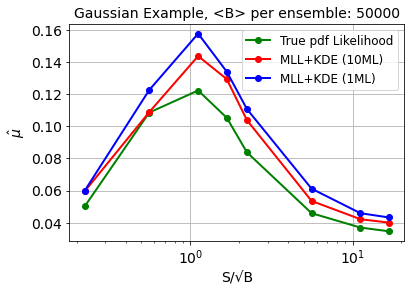

<ipython-input-109-f32d9bf46083>:40: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-ok" (-> color='k'). The keyword argument will take precedence.
  plt.plot(posX, store_Z_gaussian, '-ok', color='green', lw=lw, label=r'True pdf Likelihood')
<ipython-input-109-f32d9bf46083>:41: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-ok" (-> color='k'). The keyword argument will take precedence.
  plt.plot(posX, store_Z_bins, '-ok', color='dodgerblue', lw=lw, label=r'$\bar{x}$ BL (10 l.bins)')
<ipython-input-109-f32d9bf46083>:42: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-ok" (-> color='k'). The keyword argument will take precedence.
  plt.plot(posX, store_Z_bins_class, '-ok', color='blue', lw=lw, label=r'$o(\bar{x})$ BL (10 l.bins)')
<ipython-input-109-f32d9bf46083>:43: UserWarning: color is redundantly defined by the 'color' keyword argument and the

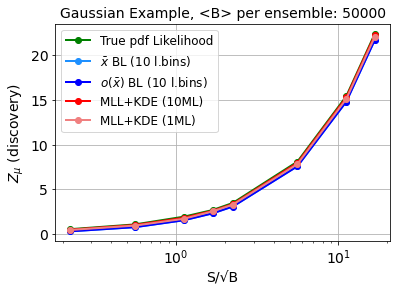

In [109]:
#########
# PLOTS #
#########

posX = []

for i in range(len(SB_ratio)):
    posX.append( (B_expected*SB_ratio[i]) / ( B_expected )**0.5 )




plt.figure()
lw = 2

plt.plot(posX, store_muhat_mean_gaussian, '-ok', color='green', lw=lw, label=r'True pdf Likelihood')
plt.plot(posX, store_muhat_mean_MLL_KDE, '-ok', color='red', lw=lw, label='MLL+KDE (10ML)')
plt.plot(posX, store_muhat_mean_MLL_KDE_1ML, '-ok', color='blue', lw=lw, label='MLL+KDE (1ML)')

#plt.xlim([0.5, 100])
#plt.ylim([-0.5, 7.5])
plt.xscale('log')
plt.xlabel('S/√B', fontsize=14)
plt.ylabel(r'$\hat{\mu}$', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.title('Gaussian Example, <B> per ensemble: %0.2d' % B_expected, fontsize=14)
plt.legend(loc="upper right", fontsize=12)
plt.show()






plt.figure()
lw = 2

plt.plot(posX, store_Z_gaussian, '-ok', color='green', lw=lw, label=r'True pdf Likelihood')
plt.plot(posX, store_Z_bins, '-ok', color='dodgerblue', lw=lw, label=r'$\bar{x}$ BL (10 l.bins)') 
plt.plot(posX, store_Z_bins_class, '-ok', color='blue', lw=lw, label=r'$o(\bar{x})$ BL (10 l.bins)') 
plt.plot(posX, store_Z_MLL_KDE, '-ok', color='red', lw=lw, label='MLL+KDE (10ML)')
plt.plot(posX, store_Z_MLL_KDE_1ML, '-ok', color='lightcoral', lw=lw, label='MLL+KDE (1ML)')
#plt.plot(posX, store_Z_MLL_KDE_mu0, '--ok', color='pink', lw=lw, label=r'MLL+KDE ($\hat{\mu}=0$)')

#plt.xlim([0.5, 10])
#plt.ylim([-0.5, 7.5])
plt.xscale('log')
plt.xlabel('S/√B', fontsize=14)
plt.ylabel('$Z_{\mu}$ (discovery)', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.title('Gaussian Example, <B> per ensemble: %0.2d' % B_expected, fontsize=14)
plt.legend(loc="upper left", fontsize=12)
plt.show()

### 4.Working points, counting over 1 bin

In [110]:
WP = [0.25, 0.5, 0.75]

S_expected = [int(SB_ratio[i]*B_expected) for i in range(len(SB_ratio))]

print(S_expected)

[50, 125, 250, 375, 500, 1250, 2500, 3750]


In [37]:
SrootB_WP0 = []
SrootB_WP1 = []
SrootB_WP2 = []


# number of background ensembles
B_ensembles = int(len(pred_XG_SM)/B_expected)

# shorten the number of B events so I get an integer number of ensembles
pred_XG_SM_entero = pred_XG_SM[:int(len(pred_XG_SM)/B_expected) * B_expected]

XG_SM_passWP0 = 0
XG_SM_passWP1 = 0
XG_SM_passWP2 = 0

for i in range(len(pred_XG_SM_entero)):
    if pred_XG_SM_entero[i] > WP[0]:
        XG_SM_passWP0 += 1
    if pred_XG_SM_entero[i] > WP[1]:
        XG_SM_passWP1 += 1
    if pred_XG_SM_entero[i] > WP[2]:
        XG_SM_passWP2 += 1



# SIGNAL

for j in range(len(S_expected)):
    
    # number of signal ensembles
    S_ensembles = int(len(pred_XG_NP)/S_expected[j])

    # shorten the number of S events so I get an integer number of ensembles
    pred_XG_NP_entero = pred_XG_NP[:int(len(pred_XG_NP)/S_expected[j]) * S_expected[j]]

    XG_NP_passWP0 = 0
    XG_NP_passWP1 = 0
    XG_NP_passWP2 = 0

    for i in range(len(pred_XG_NP_entero)):
        if pred_XG_NP_entero[i] > WP[0]:
            XG_NP_passWP0 += 1
        if pred_XG_NP_entero[i] > WP[1]:
            XG_NP_passWP1 += 1
        if pred_XG_NP_entero[i] > WP[2]:
            XG_NP_passWP2 += 1

            
    # save the results Z_binned after WP
    SrootB_WP0.append( ( XG_NP_passWP0 / S_ensembles ) / ( XG_SM_passWP0 / B_ensembles )**0.5 )
    SrootB_WP1.append( ( XG_NP_passWP1 / S_ensembles ) / ( XG_SM_passWP1 / B_ensembles )**0.5 )
    SrootB_WP2.append( ( XG_NP_passWP2 / S_ensembles ) / ( XG_SM_passWP2 / B_ensembles )**0.5 )
    
    print('S_expected = ', S_expected[j])
    print('WP: 0     S/B**0.5= ', S_expected[j]/(B_expected)**0.5)
    print('WP: ', WP[0], '    S/B**0.5= ', SrootB_WP0[j] )
    print('WP: ', WP[1], '    S/B**0.5= ', SrootB_WP1[j] )
    print('WP: ', WP[2], '    S/B**0.5= ', SrootB_WP2[j] )
    print('------------------------')
    print('')
    
print('SrootB_WP0: ', SrootB_WP0)
print('SrootB_WP1: ', SrootB_WP1)
print('SrootB_WP2: ', SrootB_WP2)

S_expected =  50
WP: 0     S/B**0.5=  0.22360679774997896
WP:  0.25     S/B**0.5=  0.2372322626838852
WP:  0.5     S/B**0.5=  0.25705810444492116
WP:  0.75     S/B**0.5=  0.20693466768091195
------------------------

S_expected =  125
WP: 0     S/B**0.5=  0.5590169943749475
WP:  0.25     S/B**0.5=  0.5930818510010795
WP:  0.5     S/B**0.5=  0.6426441139323699
WP:  0.75     S/B**0.5=  0.5173330224550401
------------------------

S_expected =  250
WP: 0     S/B**0.5=  1.118033988749895
WP:  0.25     S/B**0.5=  1.1861566924795552
WP:  0.5     S/B**0.5=  1.285299701958431
WP:  0.75     S/B**0.5=  1.0347136292632395
------------------------

S_expected =  375
WP: 0     S/B**0.5=  1.6770509831248424
WP:  0.25     S/B**0.5=  1.7792282219373938
WP:  0.5     S/B**0.5=  1.92792028386921
WP:  0.75     S/B**0.5=  1.5518751593531932
------------------------

S_expected =  500
WP: 0     S/B**0.5=  2.23606797749979
WP:  0.25     S/B**0.5=  2.3723133849591105
WP:  0.5     S/B**0.5=  2.570599403916862


In [111]:
# To use if you dont want to run everything again. Its the previous results
SrootB_WP0 = [0.2372322626838852, 0.5930818510010795, 1.1861566924795552, 1.7792282219373938, 2.3723133849591105, 5.930783462397776, 11.861566924795552, 17.792557838382876]
SrootB_WP1 = [0.25705810444492116, 0.6426441139323699, 1.285299701958431, 1.92792028386921, 2.570599403916862, 6.426498509792155, 12.85299701958431, 19.278775220224997]
SrootB_WP2 = [0.20693466768091195, 0.5173330224550401, 1.0347136292632395, 1.5518751593531932, 2.069427258526479, 5.173568146316198, 10.347136292632396, 15.518506327753672]

<ipython-input-112-91a76cdeb086>:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-ok" (-> color='k'). The keyword argument will take precedence.
  plt.plot(posX, store_muhat_mean_gaussian, '-ok', color='green', lw=lw, label=r'True pdf Likelihood')
<ipython-input-112-91a76cdeb086>:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-ok" (-> color='k'). The keyword argument will take precedence.
  plt.plot(posX, store_muhat_mean_MLL_KDE, '-ok', color='red', lw=lw, label='MLL+KDE (10ML)')
<ipython-input-112-91a76cdeb086>:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-ok" (-> color='k'). The keyword argument will take precedence.
  plt.plot(posX, store_muhat_mean_MLL_KDE_1ML, '-ok', color='blue', lw=lw, label='MLL+KDE (1ML)')


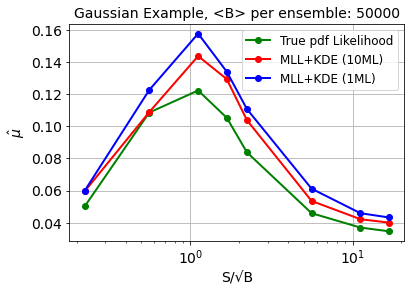

<ipython-input-112-91a76cdeb086>:40: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-ok" (-> color='k'). The keyword argument will take precedence.
  plt.plot(posX, store_Z_gaussian, '-ok', color='green', lw=lw, label=r'True pdf Likelihood')
<ipython-input-112-91a76cdeb086>:41: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-ok" (-> color='k'). The keyword argument will take precedence.
  plt.plot(posX, store_Z_MLL_KDE, '-ok', color='red', lw=lw, label='MLL+KDE (10ML)')
<ipython-input-112-91a76cdeb086>:42: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-ok" (-> color='k'). The keyword argument will take precedence.
  plt.plot(posX, store_Z_MLL_KDE_1ML, '-ok', color='lightcoral', lw=lw, label='MLL+KDE (1ML)')
<ipython-input-112-91a76cdeb086>:43: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-ok" (-> c

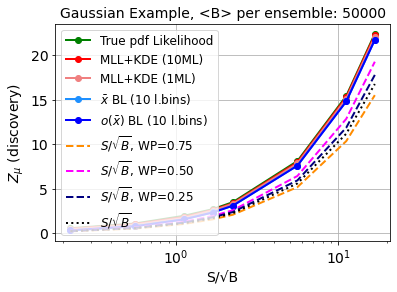

In [112]:
#########
# PLOTS #
#########

posX = []

for i in range(len(SB_ratio)):
    posX.append( (B_expected*SB_ratio[i]) / ( B_expected )**0.5 )




plt.figure()
lw = 2

plt.plot(posX, store_muhat_mean_gaussian, '-ok', color='green', lw=lw, label=r'True pdf Likelihood')
plt.plot(posX, store_muhat_mean_MLL_KDE, '-ok', color='red', lw=lw, label='MLL+KDE (10ML)')
plt.plot(posX, store_muhat_mean_MLL_KDE_1ML, '-ok', color='blue', lw=lw, label='MLL+KDE (1ML)')

#plt.xlim([0.5, 100])
#plt.ylim([-0.5, 7.5])
plt.xscale('log')
plt.xlabel('S/√B', fontsize=14)
plt.ylabel(r'$\hat{\mu}$', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.title('Gaussian Example, <B> per ensemble: %0.2d' % B_expected, fontsize=14)
plt.legend(loc="upper right", fontsize=12)
plt.show()






plt.figure()
lw = 2

plt.plot(posX, store_Z_gaussian, '-ok', color='green', lw=lw, label=r'True pdf Likelihood')
plt.plot(posX, store_Z_MLL_KDE, '-ok', color='red', lw=lw, label='MLL+KDE (10ML)')
plt.plot(posX, store_Z_MLL_KDE_1ML, '-ok', color='lightcoral', lw=lw, label='MLL+KDE (1ML)')
plt.plot(posX, store_Z_bins, '-ok', color='dodgerblue', lw=lw, label=r'$\bar{x}$ BL (10 l.bins)') 
plt.plot(posX, store_Z_bins_class, '-ok', color='blue', lw=lw, label=r'$o(\bar{x})$ BL (10 l.bins)') 
plt.plot(posX, SrootB_WP2, '--', color='darkorange', lw=lw, label=r'$S/\sqrt{B}$, WP=%0.2f' % WP[2] )
plt.plot(posX, SrootB_WP1, '--', color='magenta', lw=lw, label=r'$S/\sqrt{B}$, WP=%0.2f' % WP[1] )
plt.plot(posX, SrootB_WP0, '--', color='navy', lw=lw, label=r'$S/\sqrt{B}$, WP=%0.2f' % WP[0] )
plt.plot(posX, posX, ':', color='black', lw=lw, label=r'$S/\sqrt{B}$')

#plt.xlim([0.5, 10])
#plt.ylim([-0.5, 7.5])
plt.xscale('log')
plt.xlabel('S/√B', fontsize=14)
plt.ylabel('$Z_{\mu}$ (discovery)', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.title('Gaussian Example, <B> per ensemble: %0.2d' % B_expected, fontsize=14)
plt.legend(loc="upper left", fontsize=12)
plt.show()

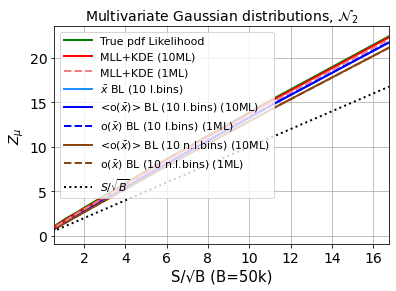

In [120]:
# FINAL PLOT

plt.figure()
lw = 2

plt.plot(posX, store_Z_gaussian, '-', color='green', lw=lw, label=r'True pdf Likelihood', zorder=5)
plt.plot(posX, store_Z_MLL_KDE, '-', color='red', lw=lw, label=r'MLL+KDE (10ML)', zorder=5)
plt.plot(posX, store_Z_MLL_KDE_1ML, '--', color='lightcoral', lw=lw, label=r'MLL+KDE (1ML)', zorder=5)
plt.plot(posX, store_Z_bins, '-', color='dodgerblue', lw=lw, label=r'$\bar{x}$ BL (10 l.bins)') 
plt.plot(posX, store_Z_bins_class, '-', color='blue', lw=lw, label=r'<o$(\bar{x})$> BL (10 l.bins) (10ML)') 
plt.plot(posX, store_Z_bins_class_1ML, '--', color='blue', lw=lw, label=r'o$(\bar{x})$ BL (10 l.bins) (1ML)')
plt.plot(posX, store_Z_bins_class_eq, '-', color='saddlebrown', lw=lw, label=r'<o$(\bar{x})$> BL (10 n.l.bins) (10ML)') 
plt.plot(posX, store_Z_bins_class_eq_1ML, '--', color='saddlebrown', lw=lw, label=r'o$(\bar{x})$ BL (10 n.l.bins) (1ML)') 
plt.plot(posX, posX, ':', color='black', lw=lw, label=r'$S/\sqrt{B}$')



plt.xlim([posX[1], posX[-1]])
plt.ylabel('$Z_{\mu}$', fontsize=14)
plt.xlabel('S/√B (B=50k)', fontsize=15)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)


plt.grid()


plt.title(r'Multivariate Gaussian distributions, $\mathcal{N}_{2}$', fontsize=14)
plt.legend(loc="upper left", fontsize=11, handlelength=2.5)
#plt.tight_layout()
#plt.savefig('images/' + '2gaussian-Z-example-2.pdf', format="pdf", bbox_inches="tight")
plt.show()

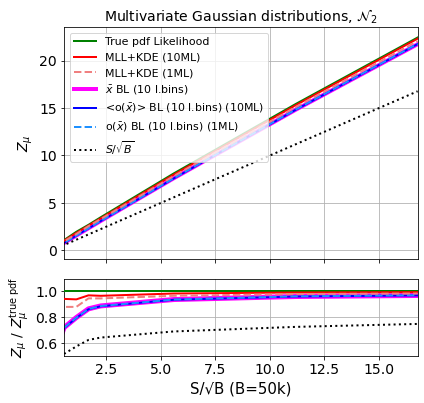

In [147]:
fig, axs = plt.subplots(2,1,figsize=(6,5.7), gridspec_kw={'height_ratios': [3, 1]})

lw = 2

axs[0].plot(posX, store_Z_gaussian, '-', color='green', lw=lw, label=r'True pdf Likelihood', zorder=5)
axs[0].plot(posX, store_Z_MLL_KDE, '-', color='red', lw=lw, label=r'MLL+KDE (10ML)', zorder=5)
axs[0].plot(posX, store_Z_MLL_KDE_1ML, '--', color='lightcoral', lw=lw, label=r'MLL+KDE (1ML)', zorder=5)
axs[0].plot(posX, store_Z_bins, '-', color='magenta', lw=4, label=r'$\bar{x}$ BL (10 l.bins)') 
axs[0].plot(posX, store_Z_bins_class, '-', color='blue', lw=lw, label=r'<o$(\bar{x})$> BL (10 l.bins) (10ML)') 
axs[0].plot(posX, store_Z_bins_class_1ML, '--', color='dodgerblue', lw=lw, label=r'o$(\bar{x})$ BL (10 l.bins) (1ML)') 
#axs[0].plot(posX, store_Z_bins_class_eq, '-', color='saddlebrown', lw=lw, label=r'<o$(\bar{x})$> BL (10 n.l.bins) (10ML)') 
#axs[0].plot(posX, store_Z_bins_class_eq_1ML, '--', color='saddlebrown', lw=lw, label=r'o$(\bar{x})$ BL (10 n.l.bins) (1ML)') 

axs[0].plot(posX, posX, ':', color='black', lw=lw, label=r'$S/\sqrt{B}$')


store_Z_gaussian_norm = [ a/b for a, b in zip(store_Z_gaussian,store_Z_gaussian)]
store_Z_MLL_KDE_norm = [ a/b for a, b in zip(store_Z_MLL_KDE,store_Z_gaussian)]
store_Z_MLL_KDE_1ML_norm = [ a/b for a, b in zip(store_Z_MLL_KDE_1ML,store_Z_gaussian)]
store_Z_bins_norm = [ a/b for a, b in zip(store_Z_bins,store_Z_gaussian)]
store_Z_bins_class_norm = [ a/b for a, b in zip(store_Z_bins_class,store_Z_gaussian)]
store_Z_bins_class_1ML_norm = [ a/b for a, b in zip(store_Z_bins_class_1ML,store_Z_gaussian)]
store_Z_bins_class_eq_norm = [ a/b for a, b in zip(store_Z_bins_class_eq,store_Z_gaussian)]
store_Z_bins_class_eq_1ML_norm = [ a/b for a, b in zip(store_Z_bins_class_eq_1ML,store_Z_gaussian)]
SrootB_WP2_norm = [ a/b for a, b in zip(SrootB_WP2,store_Z_gaussian)]
SrootB_WP1_norm = [ a/b for a, b in zip(SrootB_WP1,store_Z_gaussian)]
SrootB_WP0_norm = [ a/b for a, b in zip(SrootB_WP0,store_Z_gaussian)]
posX_norm = [ a/b for a, b in zip(posX,store_Z_gaussian)]


axs[1].plot(posX, store_Z_gaussian_norm, '-', color='green', lw=lw, label=r'True pdf Likelihood', zorder=5)
axs[1].plot(posX, store_Z_MLL_KDE_norm, '-', color='red', lw=lw, label=r'MLL+KDE (10ML)', zorder=5)
axs[1].plot(posX, store_Z_MLL_KDE_1ML_norm, '--', color='lightcoral', lw=lw, label=r'MLL+KDE (1ML)', zorder=5)
axs[1].plot(posX, store_Z_bins_norm, '-', color='magenta', lw=5, label=r'$\bar{x}$ BL (10 l.bins)') 
axs[1].plot(posX, store_Z_bins_class_norm, '-', color='blue', lw=lw, label=r'<o$(\bar{x})$> BL (10 l.bins) (10ML)') 
axs[1].plot(posX, store_Z_bins_class_1ML_norm, '--', color='dodgerblue', lw=lw, label=r'o$(\bar{x})$ BL (10 l.bins) (1ML)') 
#axs[1].plot(posX, store_Z_bins_class_eq_norm, '-', color='saddlebrown', lw=lw, label=r'<o$(\bar{x})$> BL (10 n.l.bins) (10ML)') 
#axs[1].plot(posX, store_Z_bins_class_eq_1ML_norm, '--', color='saddlebrown', lw=lw, label=r'o$(\bar{x})$ BL (10 n.l.bins) (1ML)') 
 
axs[1].plot(posX, posX_norm, ':', color='black', lw=lw, label=r'$S/\sqrt{B}$')



axs[0].set_xlim([posX[1], posX[-1]])
axs[1].set_xlim([posX[1], posX[-1]])
axs[1].set_ylim([0.5,1.1])
axs[0].set_ylabel('$Z_{\mu}$', fontsize=14)
axs[1].set_xlabel('S/√B (B=50k)', fontsize=15)
axs[1].set_ylabel(r'$Z_{\mu}$ / $Z_{\mu}^{\mathrm{true \; pdf}}$', fontsize=14)

axs[0].yaxis.set_tick_params(labelsize=14)
axs[0].xaxis.set_tick_params(labelsize=14)
axs[0].xaxis.set_ticklabels([])
axs[1].yaxis.set_ticks([0.6,0.8,1])
axs[1].xaxis.set_tick_params(labelsize=14)
axs[1].yaxis.set_tick_params(labelsize=14)

axs[0].grid()
axs[1].grid()

axs[0].set_title(r'Multivariate Gaussian distributions, $\mathcal{N}_{2}$', fontsize=14)
axs[0].legend(loc="upper left", fontsize=11)
plt.tight_layout()
plt.savefig('images/' + '2gaussian-Z-example.pdf', format="pdf", bbox_inches="tight")
plt.show()